In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats
import math

In [73]:
cd CSVs

[Errno 2] No such file or directory: 'CSVs'
/Users/ritusinghal/Desktop/Metis/mta-project-1/CSVs


#### Load Data

In [74]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])

## Clean Data

remove spaces from column names

In [75]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [76]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [77]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

Only look at regular data

In [78]:
data = data[data.DESC == 'REGULAR']
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,00:00:00,REGULAR,7053483,2390505,2019-05-11 00:00:00,A002R05102-00-0059 ST,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday


#### Find total traffic

Add shifted columns to show previous entries and exits

In [79]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data.copy()
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
grouped_time.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,05:00:00,REGULAR,5554,376,2019-05-03 05:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,01:00:00,376.0,5554.0
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,09:00:00,REGULAR,5554,376,2019-05-03 09:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,05:00:00,376.0,5554.0
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,13:00:00,REGULAR,5554,376,2019-05-03 13:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,09:00:00,376.0,5554.0
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,17:00:00,REGULAR,5554,376,2019-05-03 17:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,13:00:00,376.0,5554.0
206856,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,21:00:00,REGULAR,5554,376,2019-05-03 21:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,17:00:00,376.0,5554.0


In [80]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True)
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0


Remove counter errors from total entries/exits that occur from counters resetting

In [81]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter_ex = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter_ent = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [82]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=100000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=100000)
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS
count,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06
mean,4.148039e+07,3.396750e+07,3.396821e+07,4.148122e+07,6.120600e+02,4.912548e+02
std,2.118498e+08,1.951475e+08,1.951484e+08,2.118507e+08,4.711624e+03,4.015928e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.499730e+05,1.430240e+05,1.430260e+05,3.499680e+05,1.000000e+01,9.000000e+00
50%,2.176565e+06,1.254667e+06,1.254664e+06,2.176577e+06,7.600000e+01,5.500000e+01
75%,6.780894e+06,4.604451e+06,4.604462e+06,6.780916e+06,2.520000e+02,1.760000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,9.997500e+04,9.999600e+04


In [83]:
#find total traffic
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_ENTRIES"])) < 3)] #filtering
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time["TOTAL_EXITS"])) < 3)] #filtering
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [84]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
count,2.195987e+06,2.195987e+06,2.195987e+06,2.195987e+06,2.195987e+06,2.195987e+06,2.195987e+06
mean,4.144654e+07,3.387481e+07,3.387640e+07,4.144980e+07,1.732468e+02,1.344298e+02,3.076767e+02
std,2.117793e+08,1.948791e+08,1.948809e+08,2.117893e+08,2.461950e+02,2.152466e+02,3.723806e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.456595e+05,1.400750e+05,1.401150e+05,3.458320e+05,1.000000e+01,8.000000e+00,2.900000e+01
50%,2.168043e+06,1.246084e+06,1.246272e+06,2.168239e+06,7.300000e+01,5.200000e+01,1.710000e+02
75%,6.767464e+06,4.580796e+06,4.581009e+06,6.767599e+06,2.400000e+02,1.660000e+02,4.550000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,2.294000e+03,2.289000e+03,2.302000e+03


drop uneeded columns

In [85]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME','DESC', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS', 'TOTAL_ENTRIES', 'TOTAL_EXITS'], axis=1, inplace=True)

### Add Location and Income data

load location data to get borough info and latitude/longitude information

In [86]:
loc_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
#print(loc_data.Borough.unique())
#loc_df.tail()
#print(loc_df[loc_df['GTFS Latitude']== 40.750580])

In [87]:
#add borough_name column
burough_dict = { 'Q': 'Queens', 'M': 'Manhattan', 'Bk':'Brooklyn', 'Bx': 'Bronx', 'SI': 'Staten Island'}
loc_df['Borough_Name'] = loc_df['Borough'].map(burough_dict)

In [88]:
#drop uneeded columns
loc_df.drop(['Borough','Line','Station ID','Complex ID', 'GTFS Stop ID', 'Line', 'Structure', 
               'Daytime Routes', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Notes'], axis=1, inplace =True)

Rename columns in loc_data to merge on STATION and DIVISION

In [89]:
#stations were found to have the same but located in diff areas so DIVISION was also used
loc_df.rename(columns = {'Stop Name':'STATION', 'Division':'DIVISION','GTFS Latitude':'Latitude','GTFS Longitude':'Longitude'}, inplace = True) 
loc_df['STATION'] = loc_df['STATION'].str.upper()
#replace some strings in loc_df to match grouped_time station names
loc_df['STATION'] = loc_df['STATION'].str.replace('STATION', 'STA')
loc_df['STATION'] = loc_df['STATION'].str.replace('GRAND CENTRAL', 'GRD CNTRL')
loc_df['STATION'] = loc_df['STATION'].str.replace('42 ST-PORT AUTHORITY BUS TERMINAL', '42 ST-PORT AUTH')
#join with grouped_time
station_loc_df = grouped_time.merge(loc_df, how = 'inner', on = ['STATION'])
#station_loc_df.tail()
#print(station_loc_df[station_loc_df['STATION']=='28 ST'])
#print(station_loc_df[station_loc_df['STATION']=='34 ST-PENN STA'])

Add income data

In [90]:
#import income data
income_data = pd.read_csv('https://raw.githubusercontent.com/hollyyuqizheng/transportation-transformation/master/data/new_york/new%20york%20income%20data.csv')
#print(loc_data.Borough.unique())
#income_data.head()

In [91]:
#new df grouped by latitude, longitude, and station
station_lat_long_df = station_loc_df.groupby(['Latitude','Longitude', 'STATION','Borough_Name'], as_index=False ).TOTAL_TRAFFIC.sum()
station_lat_long_df.drop_duplicates('STATION',keep='first', inplace=True)
#print(station_lat_long_df[station_lat_long_df['STATION']=='28 ST'])

Find average income for each station

In [92]:
def find_min_dist(row):
    '''
    row from station_income_df as argument
    loop through income_df to find closest zip code based on latitude and longitude
    return Avg income of closest zip code to station
    '''
    min_dist = 1000
    idx = 0
    for index, r in income_data.iterrows():
        l = r[1].split(", ")
        l = [float(i) for i in l]
        a = ((l[0] - row['Latitude'])**2 + (l[1] - row['Longitude'])**2)
        a = abs(a)
        dist = math.sqrt(a)
        if dist < min_dist:
            min_dist = dist
            idx = index
    return income_data.iloc[idx]['Avg. Income/H/hold']

In [93]:
#new df that includes station income, location, and traffic info
station_income_df = station_lat_long_df.copy()
#apply function to find income info based on location, sort data by decreasing incomes
station_income_df['Avg_Income'] = station_income_df.apply(find_min_dist, axis=1) 
station_income_df.sort_values('Avg_Income', ascending=False, inplace=True)
#avg income in the thousands
station_income_df['Avg_Income'] = station_income_df['Avg_Income']/1000 
#print(station_income_df)

In [94]:
#find total income of all stations
total_income = station_income_df['Avg_Income'].sum()

new df with income and traffic data sorted by traffic

In [95]:
top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
#total traffic in the millions
top_traffic_stations_df['TOTAL_TRAFFIC'] = top_traffic_stations_df['TOTAL_TRAFFIC']/1000000

In [96]:
#find total traffic
total_traffic = top_traffic_stations_df['TOTAL_TRAFFIC'].sum()

new dfs for top 50 income and traffic, and income/traffic combined 

In [97]:
#find incoem and traffic percentiles by dividing income/traffic by total income/traffic across all stations
top50_income = station_income_df.head(50)
top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100

top50_traffic = top_traffic_stations_df.head(50)
top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100

#drop uneeded columns before merging
top50_income.drop([ 'Avg_Income'], axis=1, inplace=True)
top50_traffic.drop([ 'Avg_Income'], axis=1, inplace=True)

<ipython-input-97-1b0bd960d1e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100
<ipython-input-97-1b0bd960d1e0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100
/Users/ritusinghal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [98]:
#new df containing stations in both the top 50 income and top 50 traffic
top_50_df = top50_income.merge(top50_traffic, how = 'inner', on = ['STATION', 'Borough_Name'])

#new total percentile col and sort df by decreasing total percentile
top_50_df['Total_Percentile'] = top_50_df['Traffic_Percentile'] + top_50_df['Income_Percentile']
top_50_df.sort_values('Total_Percentile', ascending=False, inplace=True)

In [99]:
#new df stations with containing top 10 total percentiles
top10_rank_df = top_50_df.head(10)

## Top Traffic Stations Based on Income and Traffic

### Top 10 Highest Trafffic Stations

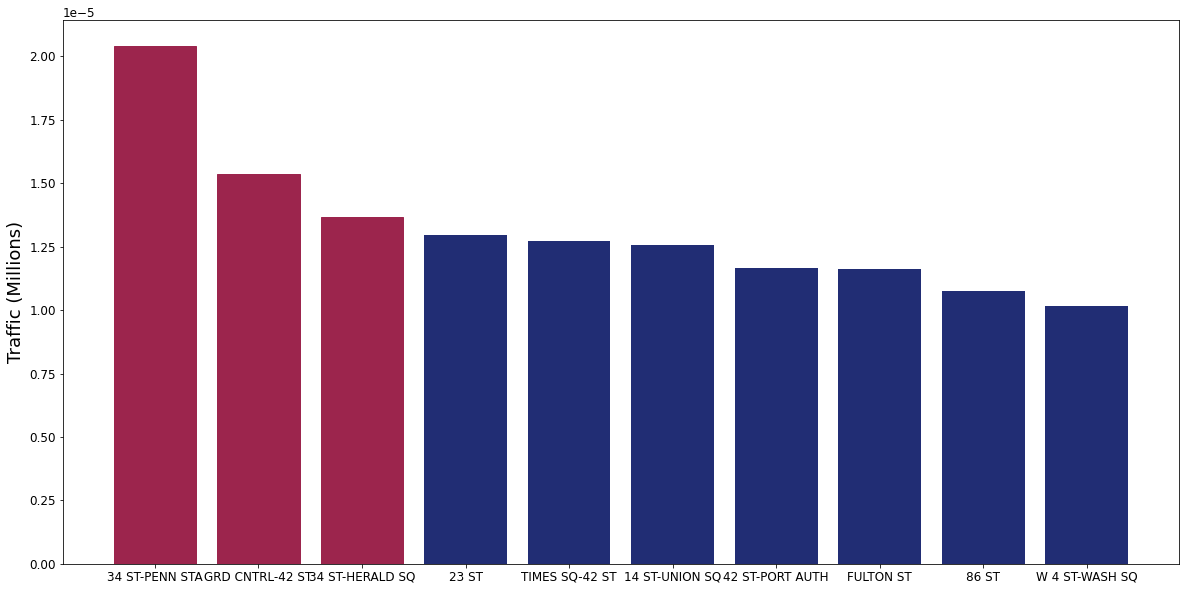

In [100]:
plt.rcParams['font.size']= 12
#only need top 10
top10_station_traffic_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top10_station_traffic_df['Avg_Income'] = top10_station_traffic_df['Avg_Income']/1000
top10_station_traffic_df['TOTAL_TRAFFIC'] = top10_station_traffic_df['TOTAL_TRAFFIC']/1000000

#plot
top_traf_bar = plt.bar(top10_station_traffic_df['STATION'], top10_station_traffic_df['TOTAL_TRAFFIC'], color='#212d74')
plt.ylabel("Traffic (Millions)",fontsize=18)

#highlight stations in with top 10 incomes and traffic
top_traf_bar[0].set_color('#9c254d')
top_traf_bar[1].set_color('#9c254d')
top_traf_bar[2].set_color('#9c254d')

#plt.savefig('top10_traf_bar.png', dpi=300)
plt.show()

### Top 10 Stations in Highest Income Areas

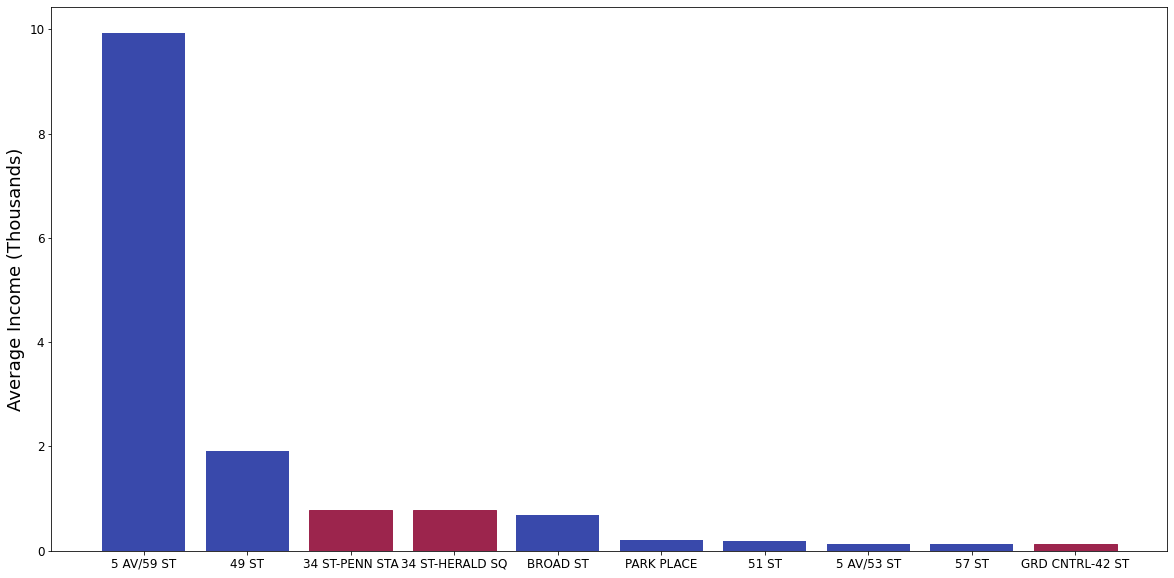

In [32]:
plt.rcParams['font.size']= 12
#only need top 10
top_station_income_df = station_income_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)

#income in thousands, traffic in millions
top_station_income_df['Avg_Income'] = top_station_income_df['Avg_Income']/1000
top_station_income_df['TOTAL_TRAFFIC'] = top_station_income_df['TOTAL_TRAFFIC']/1000000

#plot
top_inc_bar = plt.bar(top_station_income_df['STATION'], top_station_income_df['Avg_Income'], color='#3949ab')
plt.ylabel("Average Income (Thousands)",fontsize=18)

#highlight stations in with top 10 incomes and traffic
top_inc_bar[3].set_color('#9c254d')
top_inc_bar[2].set_color('#9c254d')
top_inc_bar[9].set_color('#9c254d')

#plt.savefig('top10_inc_bar.png', dpi=300)
plt.show()

### Top 10 stations for both Income and Traffic 

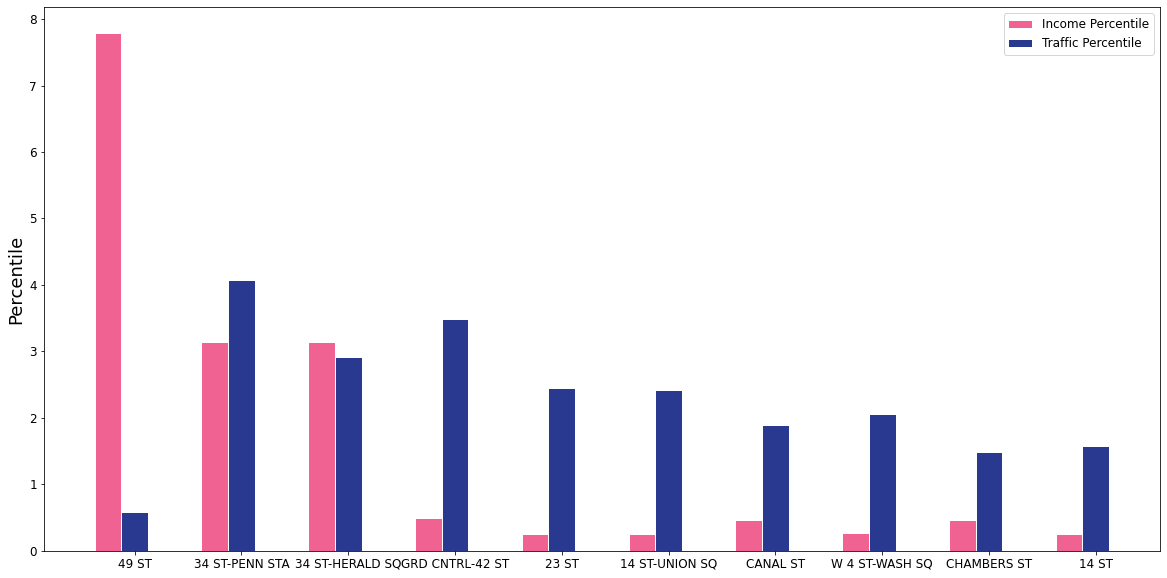

In [33]:
barWidth = 0.25
r1 = np.arange(len(top10_rank_df['STATION']))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1,top10_rank_df['Income_Percentile'], color= '#f06292', width=barWidth, edgecolor='white', label='Income Percentile')
plt.bar(r2, top10_rank_df['Traffic_Percentile'], color='#2a3990', width=barWidth, edgecolor='white', label='Traffic Percentile')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(top10_rank_df['Traffic_Percentile']))], top10_rank_df['STATION'])
 
plt.rcParams['font.size']= 12
plt.ylabel("Percentile",fontsize=18)
plt.legend()
#plt.savefig('top10_rank_bar.png', dpi=300)
plt.show()

## Compare Boroughs

### Graph number of stations in each borough

<BarContainer object of 5 artists>

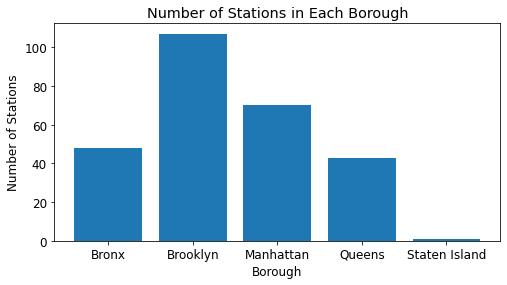

In [34]:
borough_station_count_df = station_loc_df.groupby('Borough_Name')['STATION'].nunique().reset_index()
plt.rcParams["figure.figsize"] = (8, 4)
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.title("Number of Stations in Each Borough")
plt.bar(borough_station_count_df['Borough_Name'], borough_station_count_df['STATION'])

### Graph total traffic in each Borough 

<BarContainer object of 5 artists>

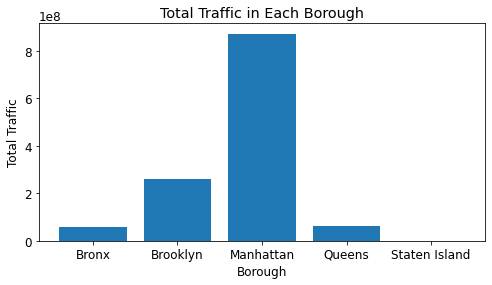

In [35]:
borough_traffic_df = station_loc_df.groupby('Borough_Name').TOTAL_TRAFFIC.sum().reset_index()
plt.xlabel("Borough")
plt.ylabel("Total Traffic")
plt.title("Total Traffic in Each Borough")
plt.bar(borough_traffic_df['Borough_Name'], borough_traffic_df['TOTAL_TRAFFIC'])

### Find top 5 stations in each borough and graph

In [36]:
#bew df with top 5 in each borough by traffic sorted
borough_top5_df = station_loc_df.groupby(['Borough_Name','STATION']).agg({'TOTAL_TRAFFIC':'sum'}, asindex=False)
borough_top5_df = borough_top5_df['TOTAL_TRAFFIC'].groupby('Borough_Name', group_keys=False)
borough_top5_df = borough_top5_df.apply(lambda x: x.sort_values(ascending=False).head(5))
borough_top5_df

Borough_Name   STATION        
Bronx          FORDHAM RD          5020206.0
               167 ST              4645166.0
               KINGSBRIDGE RD      4505952.0
               170 ST              4130198.0
               GUN HILL RD         3450604.0
Brooklyn       86 ST              25797912.0
               CHURCH AV          15777033.0
               FULTON ST          14657662.0
               KINGS HWY          12601506.0
               7 AV               10612046.0
Manhattan      23 ST              70800200.0
               CANAL ST           65664786.0
               GRD CNTRL-42 ST    60331374.0
               FULTON ST          58630648.0
               TIMES SQ-42 ST     55958712.0
Queens         111 ST              6122097.0
               WOODHAVEN BLVD      6089928.0
               COURT SQ            5935204.0
               36 ST               2846419.0
               JUNCTION BLVD       2838276.0
Staten Island  TOMPKINSVILLE        247600.0
Name: TOTAL_TRAFFIC, dty

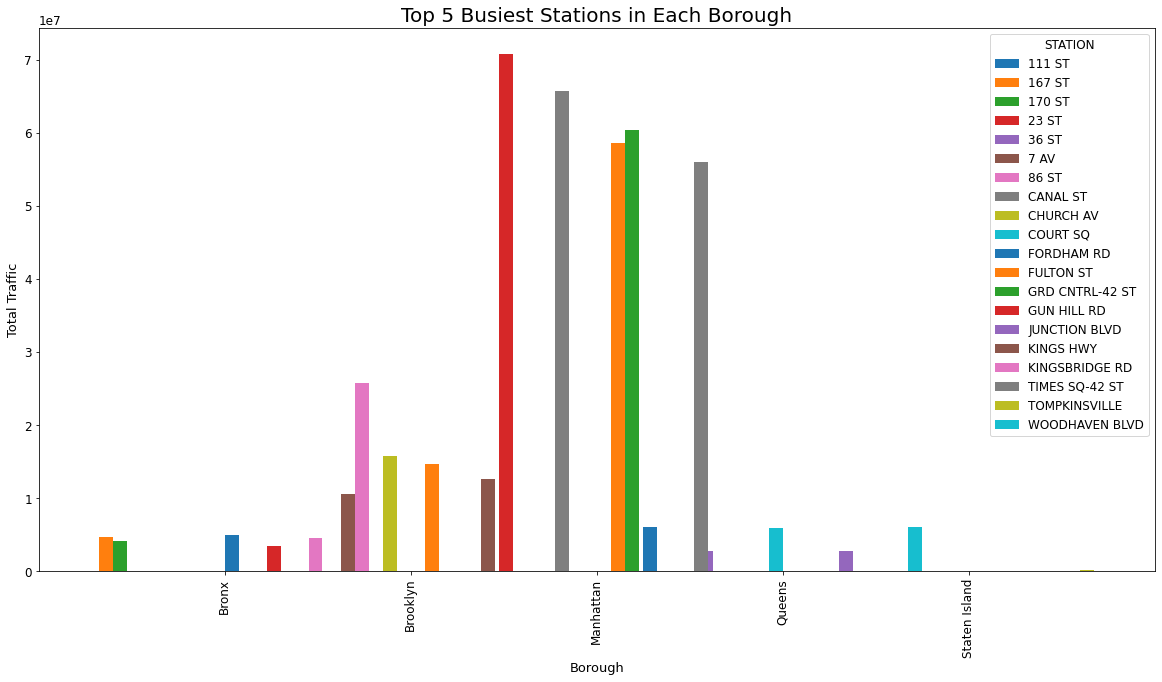

In [37]:
rcParams['figure.figsize'] = 20,10
borough_top5_df.unstack().plot.bar(width=1.5)
#plt.bar([0,2,3,4],borough_top5_df.unstack(),width=1.5)
#plt.bar(borough_top5_df.unstack(),width=1.5)
plt.title("Top 5 Busiest Stations in Each Borough", fontsize=20)
plt.ylabel("Total Traffic",fontsize=13)
plt.xlabel("Borough",fontsize=13)
plt.rcParams.update({'font.size': 9})
#plt.tight_layout()
 
#borough_top5_df.unstack().plot.bar()

### Find high traffic days

In [38]:
#find max and min of lat and long
BBox = (station_lat_long_df.Longitude.min(),   station_lat_long_df.Longitude.max(),      
         station_lat_long_df.Latitude.min(), station_lat_long_df.Latitude.max())
BBox

(-74.074835, -73.761353, 40.576312, 40.898379)

In [39]:
cd - 

/Users/patrickbovard/Documents/GitHubRepos/mta-project-1


In [40]:
ruh_m = plt.imread('NYC_Map.png') #load NYC Map

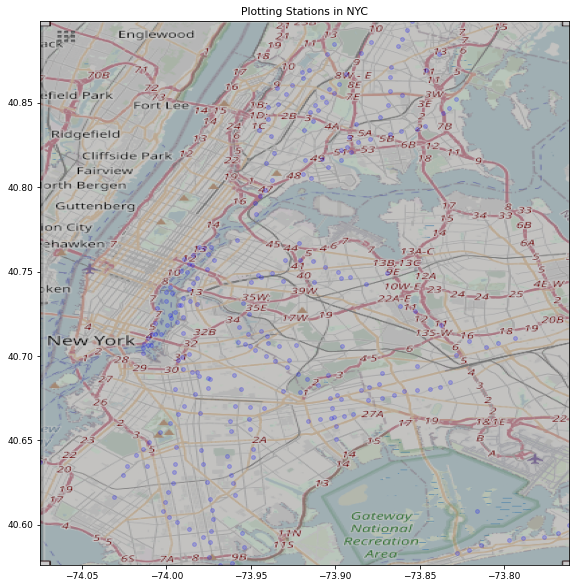

In [41]:
fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(station_lat_long_df.Longitude, station_lat_long_df.Latitude, zorder=1, alpha= 0.2, c='b', s=15)
ax.set_title('Plotting Stations in NYC')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

### Find high traffic days

In [157]:
Total_Weekly_ridership = grouped_time.groupby(['Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
#Total_Weekly_ridership.sort_values(by=['TOTAL_TRAFFIC'],inplace = True, ascending = False)
Total_Weekly_ridership.head()
list(Total_Weekly_ridership.columns)

['Week_Day', 'TOTAL_TRAFFIC']

<AxesSubplot:xlabel='Week_Day'>

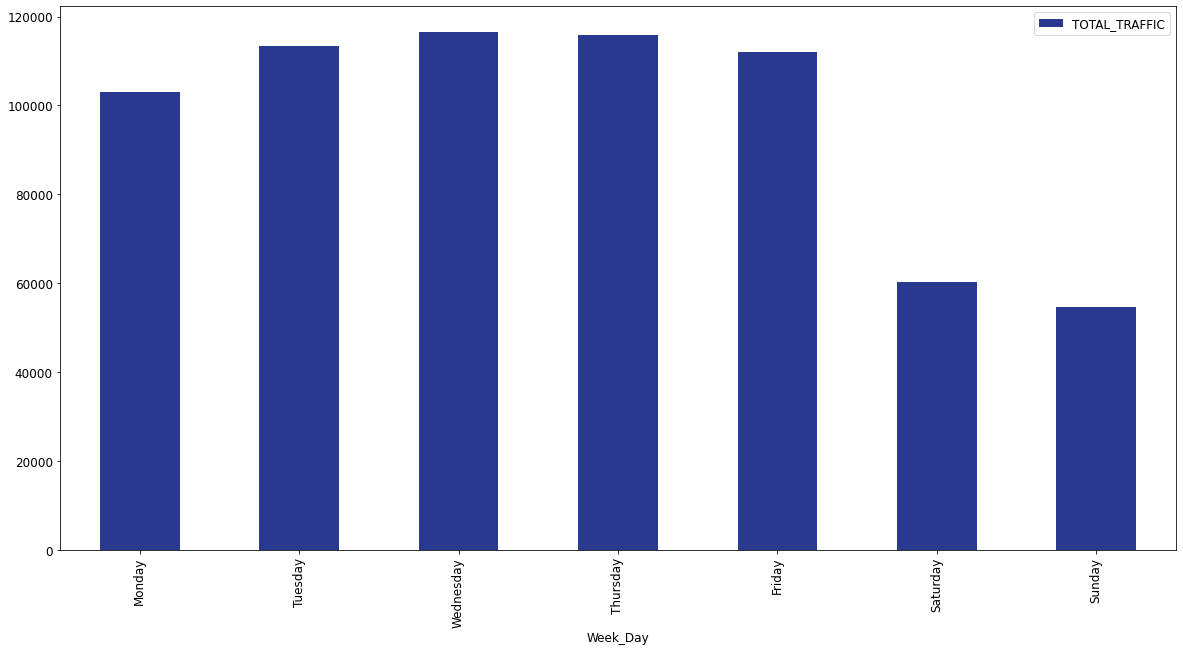

In [158]:
#timeaxis_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
#Total_Weekly_ridership = Total_Weekly_ridership.loc[timeaxis_list]
#Total_Weekly_ridership['Week_Day'] = pd.Categorical(Total_Weekly_ridership['Week_Day'], categories=
#    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
#    ordered=True)
Total_Weekly_ridership.columns = ['Week_Day','TOTAL_TRAFFIC']
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = Total_Weekly_ridership['Week_Day'].map(mapping)
Total_Weekly_ridership = Total_Weekly_ridership.iloc[key.argsort()].set_index('Week_Day')
#Total_Weekly_ridership.sort_index()
#top_inc_bar = plt.bar(Total_Weekly_ridership['Week_Day'],Total_Weekly_ridership['TOTAL_TRAFFIC']//1000,color = 'blue')
#plt.xlabel("Day of the Week", fontsize=18)
#plt.ylabel("Total Traffic on each Weekday (Thousands)",fontsize=18)
#plt.title("Sum of Weekly Traffic for all stations",fontsize=27)
#plt.rcParams.update({'font.size': 12})
#top_inc_bar[5].set_color('violet')
#top_inc_bar[6].set_color('violet')
#for j in range[5]:
#top_inc_bar[0].set_color('#2a3990')
#top_inc_bar[1].set_color('#2a3990')
#top_inc_bar[2].set_color('#2a3990')
#top_inc_bar[3].set_color('#2a3990')
#top_inc_bar[4].set_color('#2a3990')
#top_inc_bar[5].set_color('#f06292')
#top_inc_bar[6].set_color('#f06292')    
#plt.savefig('total_weekly_traffic.png', dpi=300)
list(Total_Weekly_ridership.columns)
# list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
#my_colors = list(islice(cycle(['#2a3990','#2a3990','#2a3990','#2a3990','#2a3990','#f06292','#f06292']), None, len(Total_Weekly_ridership)))
my_colors = ['#2a3990','#2a3990','#2a3990','#2a3990','#2a3990','#f06292','#f06292']
Total_Weekly_ridership['TOTAL_TRAFFIC'] = Total_Weekly_ridership['TOTAL_TRAFFIC']//1000
Total_Weekly_ridership.plot(kind = 'bar',color = my_colors)

Based on this it seems like Total weekend traffic is much more compared to the weekday - So WTWY should focus on weekdays more

## High traffic Day trend for top 5 busy stations

In [56]:
Total_ridership = grouped_time.groupby(['STATION']).TOTAL_TRAFFIC.sum().reset_index()
Total_ridership.sort_values(by=['TOTAL_TRAFFIC'],inplace = True, ascending = False)
Total_ridership.head()
#top_traffic_stations_df.head()

,STATION,TOTAL_TRAFFIC
61,34 ST-PENN STA,17447921.0
46,23 ST,11238907.0
225,FULTON ST,11060225.0
232,GRD CNTRL-42 ST,10440672.0
352,TIMES SQ-42 ST,9734947.0


In [105]:
#Top5 = Total_ridership['STATION'][0:5].tolist()
Top5 = top10_station_traffic_df['STATION'][0:5].tolist()
Top5
Top5_stations = grouped_time[grouped_time['STATION'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['STATION','Week_Day']).TOTAL_TRAFFIC.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['STATION','DATE']).TOTAL_TRAFFIC.sum().reset_index()

#### Weekly plot for Top 5 Stations

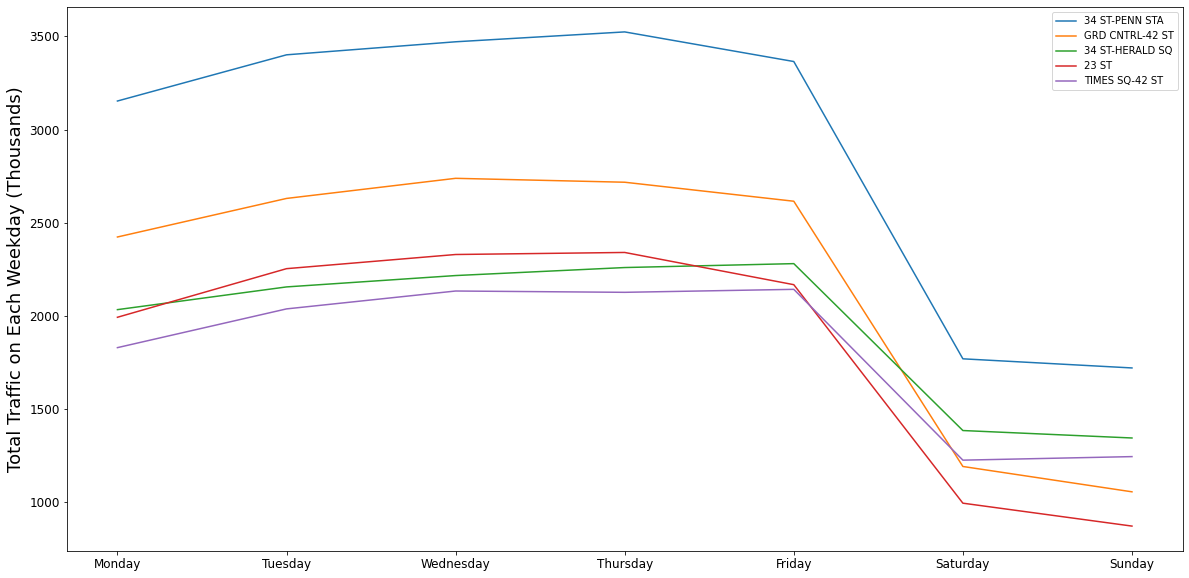

In [106]:
timeaxis_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['STATION'] == stations]
    station = station.set_index('Week_Day').loc[timeaxis_list]
    plt.plot(station['TOTAL_TRAFFIC']//1000,label = stations)
plt.ylabel("Total Traffic on Each Weekday (Thousands)",fontsize=18)
#plt.title("Weekly Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_weekly_traffic.png', dpi=300)
plt.legend()
plt.show()



This plot also corroborated the results from combined stations results that weekends show a dip

#### Daily Traffic for Top 5

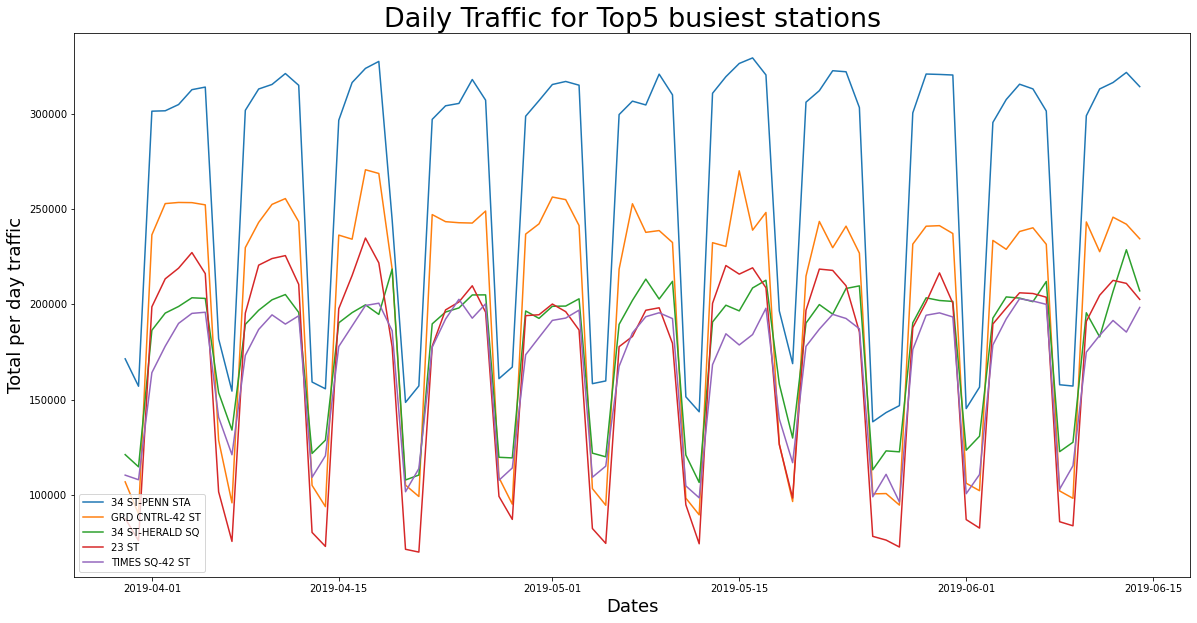

In [107]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['STATION'] == stations]
    plt.plot(station['DATE'],station['TOTAL_TRAFFIC'],label = stations)
plt.xlabel("Dates", fontsize=18)
plt.ylabel("Total per day traffic",fontsize=18)
plt.title("Daily Traffic for Top5 busiest stations",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('top5_daily_traffic.png', dpi=300)
plt.legend()
plt.show()

## Find Peak Hours

In [108]:
#Top10 = Total_ridership['STATION'][0:10].tolist()
Top10 = top10_station_traffic_df['STATION'][0:10].tolist()
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_hourly = Top10_stations.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
Top10_station_hourly.head()

,STATION,TIME,TOTAL_TRAFFIC
0,14 ST-UNION SQ,01:00:00,1155702.0
1,14 ST-UNION SQ,05:00:00,161086.0
2,14 ST-UNION SQ,07:28:40,3613.0
3,14 ST-UNION SQ,07:36:05,645.0
4,14 ST-UNION SQ,08:11:07,6078.0


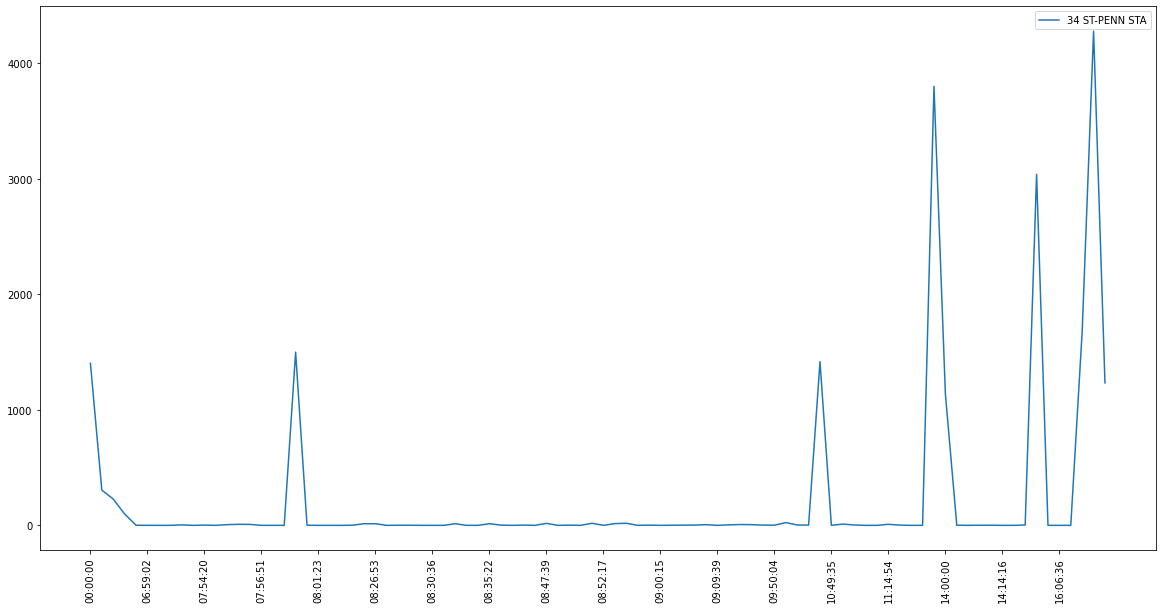

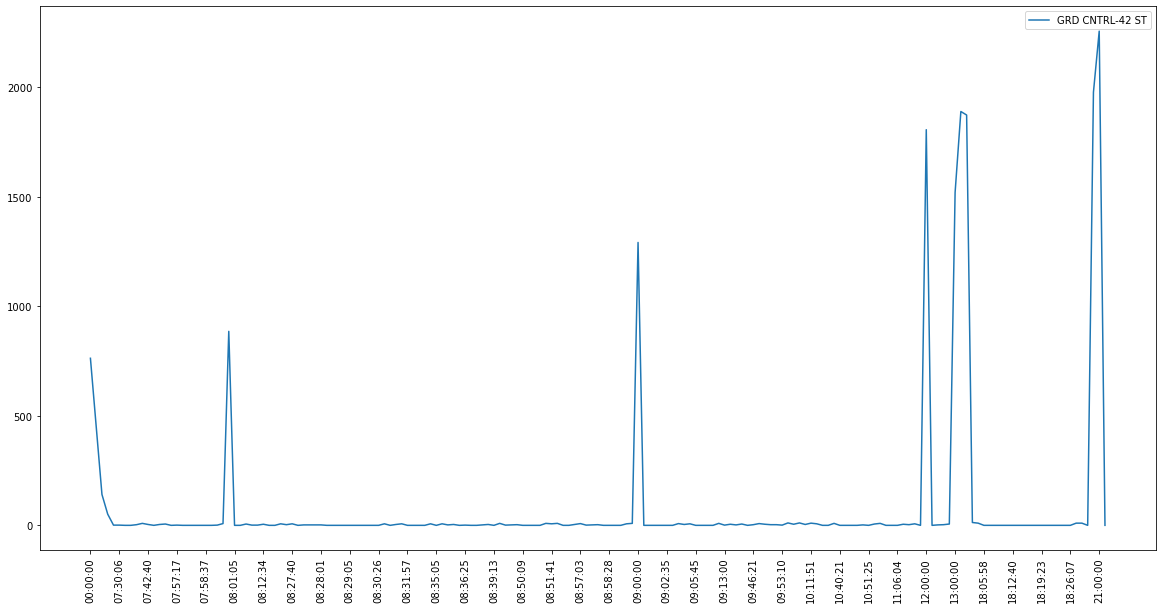

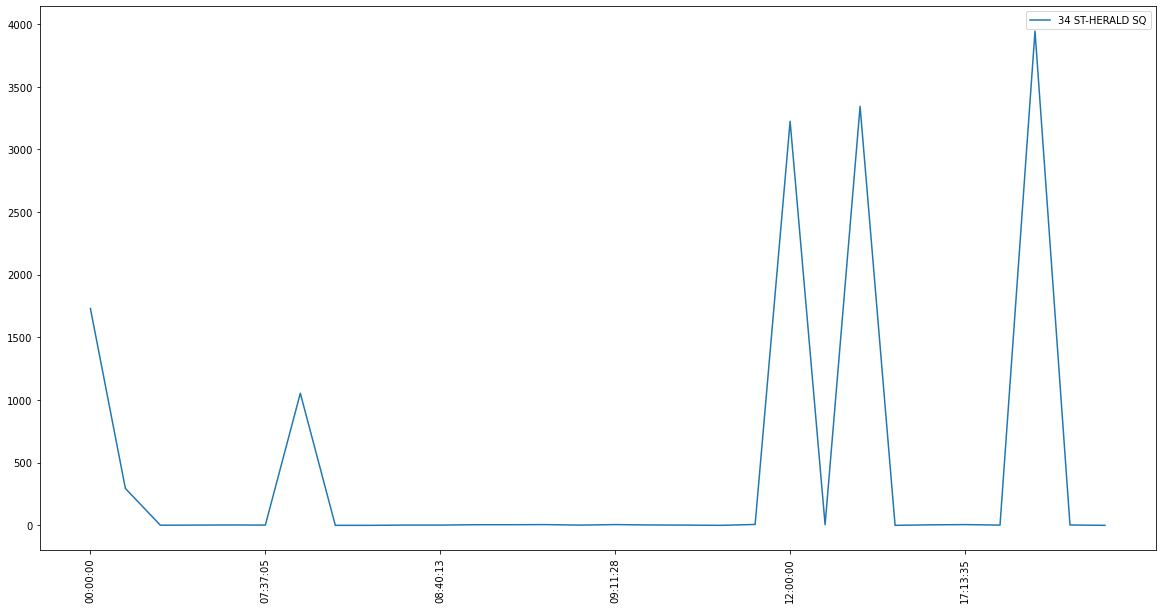

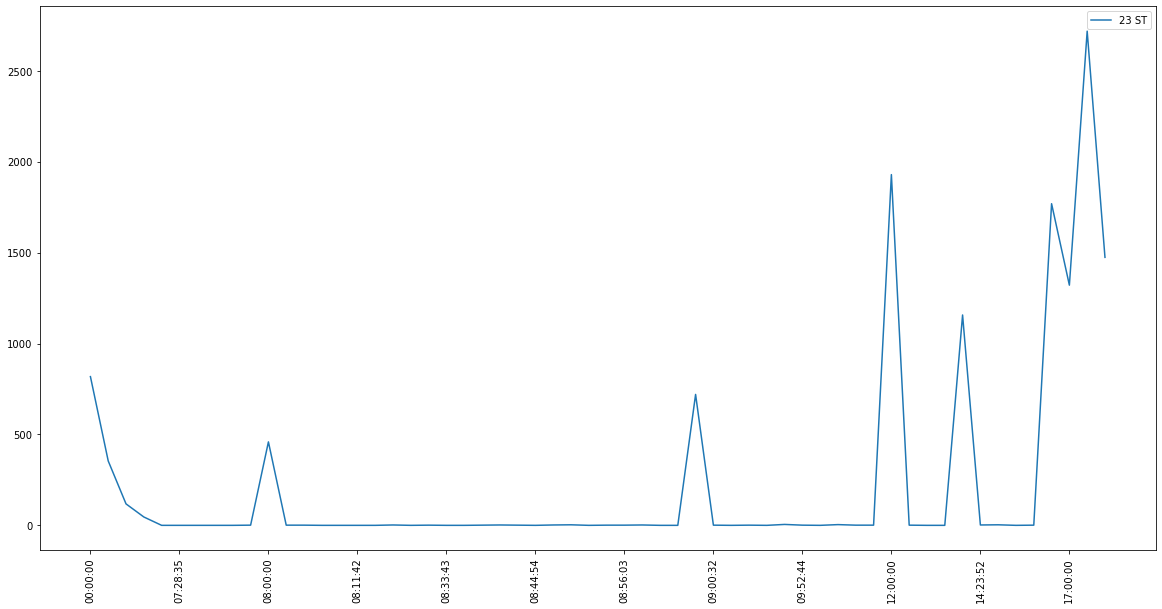

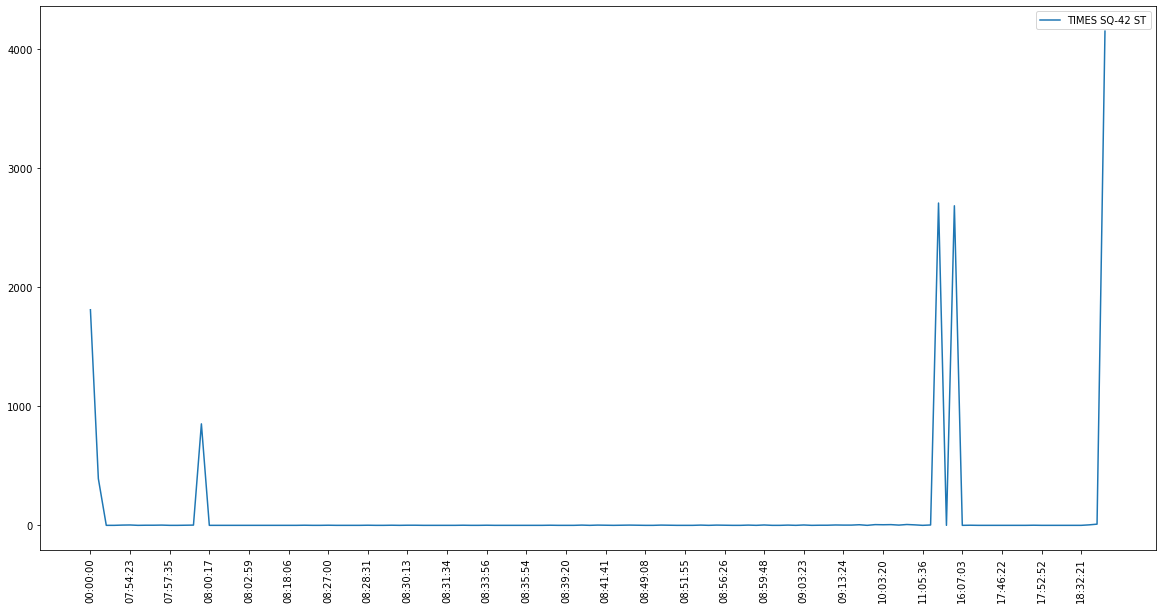

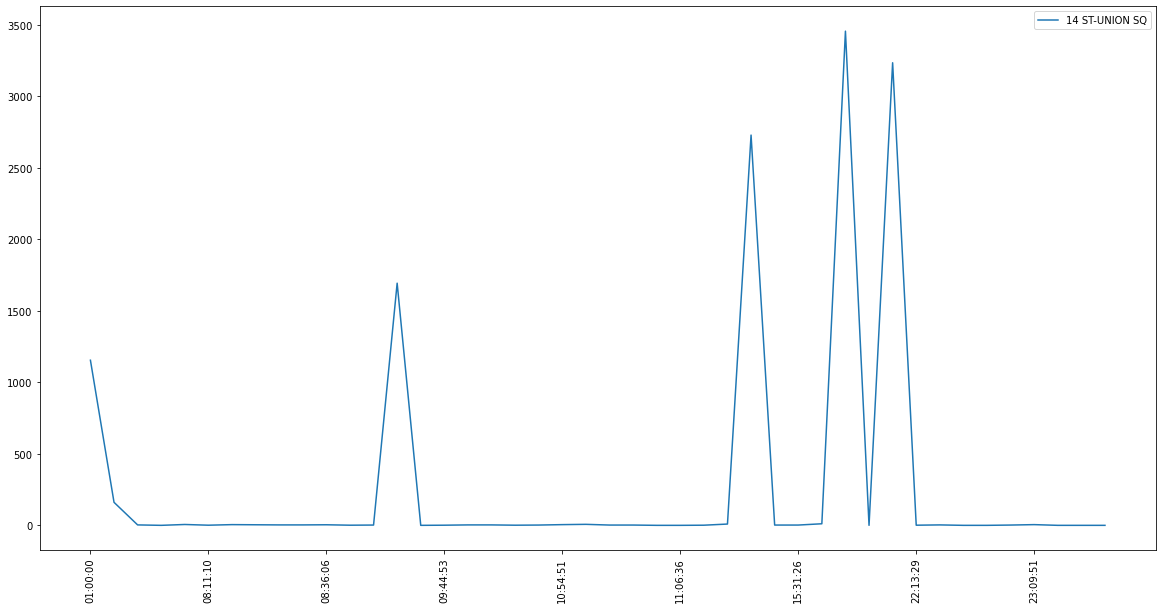

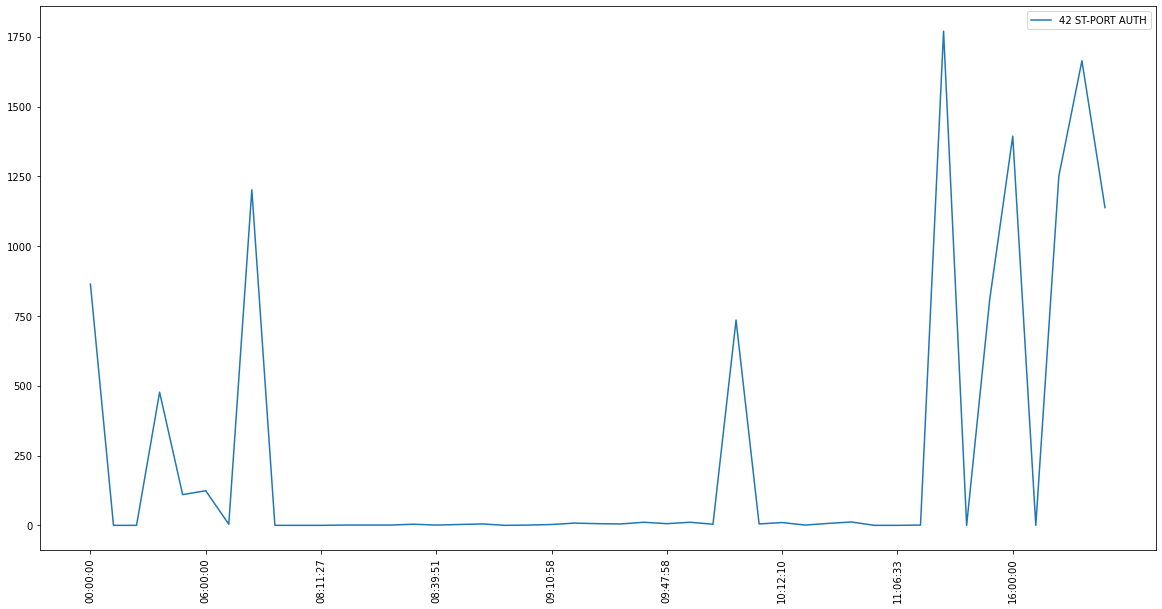

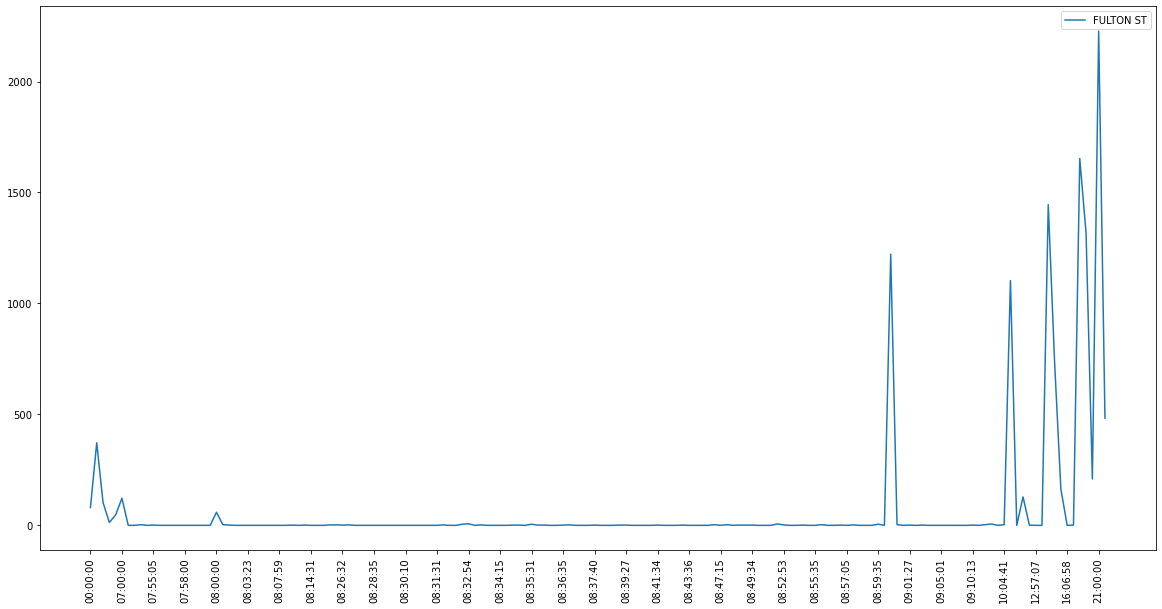

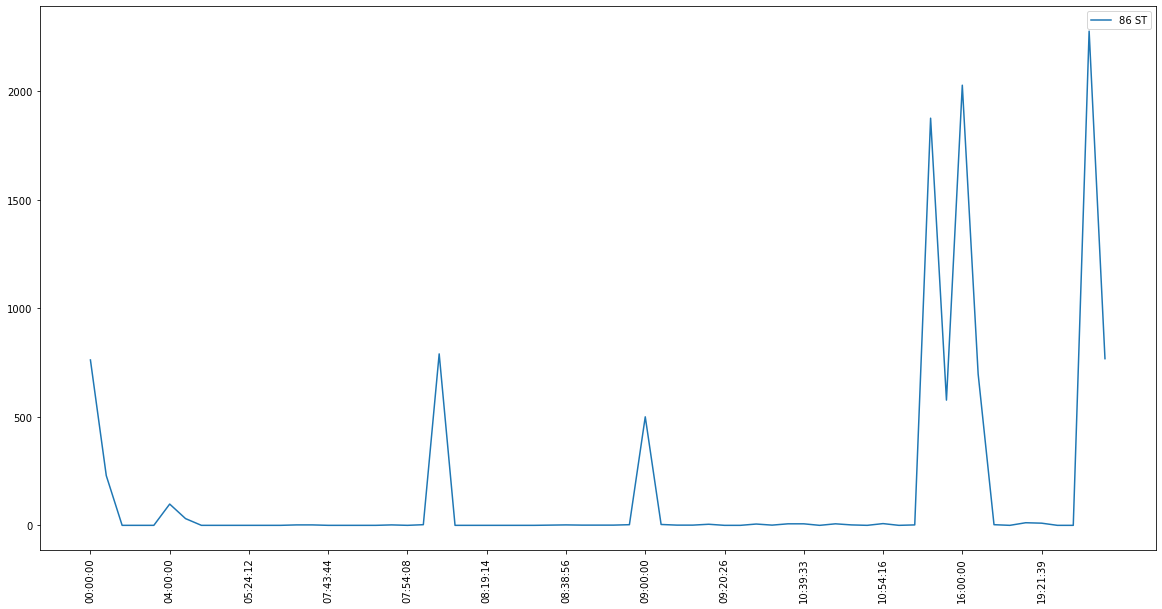

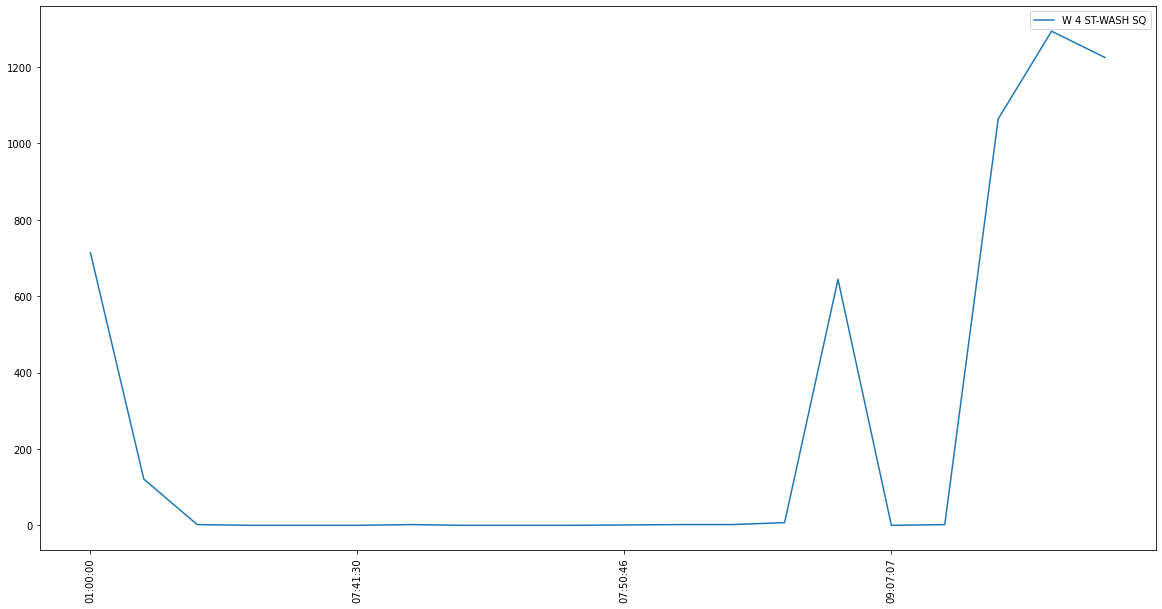

In [109]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
for stations in Top10:
     station = Top10_station_hourly[Top10_station_hourly['STATION'] == stations]
#    print(station)
     fig, ax = plt.subplots()
     ax.plot(station['TIME'],station['TOTAL_TRAFFIC']//1000,label = stations)
     ax.set_xticks(ax.get_xticks()[::5])
     plt.xticks(rotation = 'vertical')
     plt.legend()
plt.legend()
plt.show()

#### WTC always busy

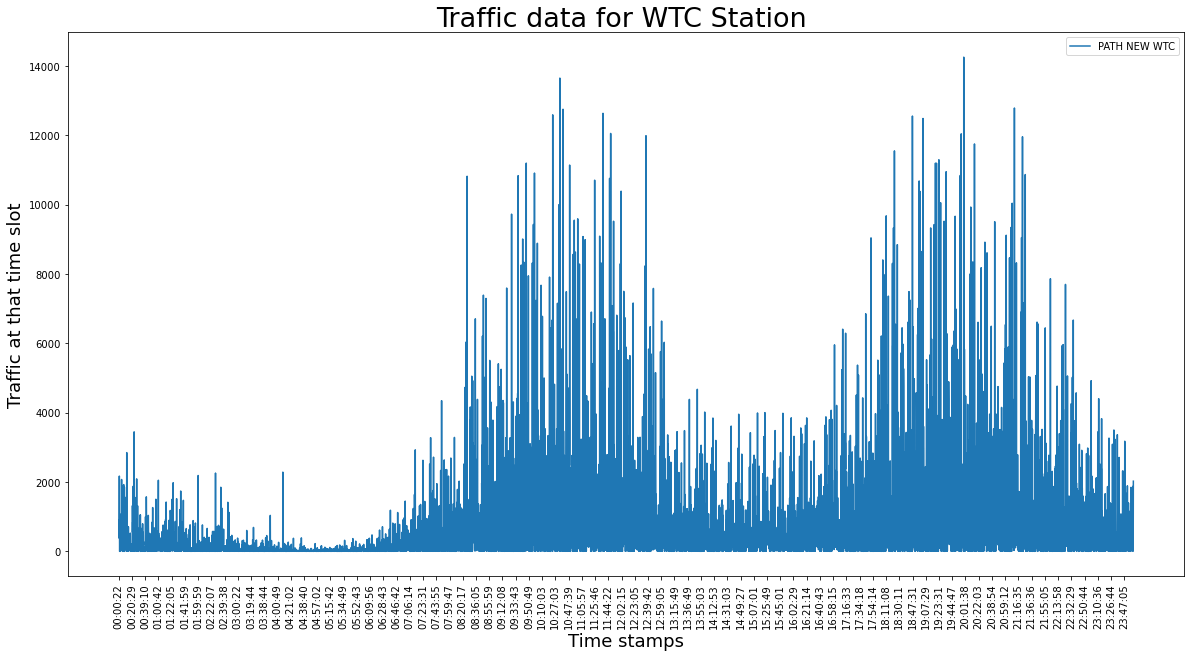

In [110]:
wtc_station = grouped_time[grouped_time['STATION'] == "PATH NEW WTC"]
wtc_station_hourly = wtc_station.groupby(['STATION','TIME']).TOTAL_TRAFFIC.sum().reset_index()
fig, ax = plt.subplots()
ax.plot(wtc_station_hourly['TIME'],wtc_station_hourly['TOTAL_TRAFFIC'],label = "PATH NEW WTC")
ax.set_xticks(ax.get_xticks()[::100])
plt.xticks(rotation = 'vertical')
plt.xlabel("Time stamps", fontsize=18)
plt.ylabel("Traffic at that time slot",fontsize=18)
plt.title("Traffic data for WTC Station ",fontsize=27)
plt.rcParams.update({'font.size': 10})
plt.savefig('WTC_traffic.png', dpi=300)
plt.legend()
plt.show()

## Finding time of day for high traffic

In [111]:
grouped_time['FIRST'] =  grouped_time.TIME.astype(str).str[:2].astype(int) #grabbing first two numbers of timestamp

In [112]:
def make_time_bins(row):
#    print(row['FIRST'])
    if (row['FIRST'] >=0 and row['FIRST'] <= 4):
  #      print("I am in night")
        return "Night"
    elif (row['FIRST'] >4 and row['FIRST'] <= 8):
 #       print("I am in early morning")
        return "Early Morning"
    elif (row['FIRST'] >8 and row['FIRST'] < 12):
        return "Morning"
    elif (row['FIRST'] >=12 and row['FIRST'] < 17):
        return "Afternoon"
    elif (row['FIRST'] >=17 and row['FIRST'] < 21):
        return "Evening"
    else: return "Night"
    return 

In [113]:
grouped_time["TIME_BINS"] = grouped_time.apply(make_time_bins, axis=1)
grouped_time.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,FIRST,TIME_BINS
1,59 ST,BMT,2019-05-11,04:00:00,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,31.0,4,Night
2,59 ST,BMT,2019-05-11,08:00:00,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,51.0,8,Early Morning
3,59 ST,BMT,2019-05-11,12:00:00,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,144.0,12,Afternoon
4,59 ST,BMT,2019-05-11,16:00:00,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,282.0,16,Afternoon
5,59 ST,BMT,2019-05-11,20:00:00,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,339.0,20,Evening


In [114]:
Top10_stations = grouped_time[grouped_time['STATION'].isin(Top10)]
Top10_station_slot = Top10_stations.groupby(['STATION','TIME_BINS']).TOTAL_TRAFFIC.sum().reset_index()

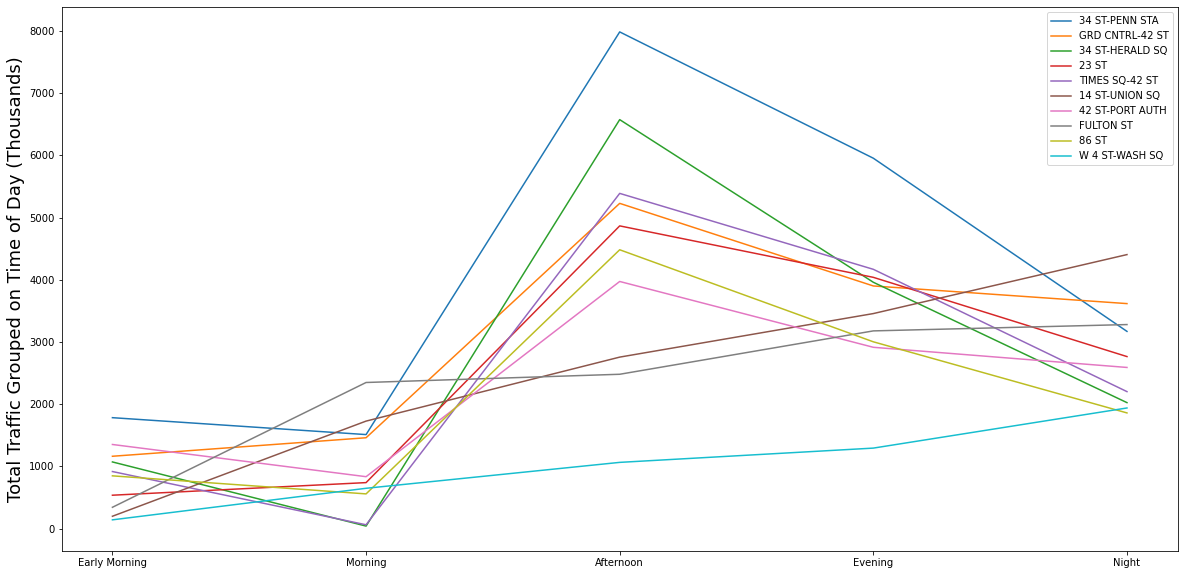

In [115]:
timeaxis_list = ["Early Morning", "Morning", "Afternoon", "Evening", "Night"]

for stations in Top10:
    station = Top10_station_slot[Top10_station_slot['STATION'] == stations]
    station = station.set_index('TIME_BINS').loc[timeaxis_list]
    plt.plot(station['TOTAL_TRAFFIC']/1000,label = stations)
    
plt.ylabel("Total Traffic Grouped on Time of Day (Thousands)",fontsize=18)
plt.rcParams.update({'font.size': 10})
plt.legend()
plt.savefig('Traffic_trend.png',dpi = 300)
plt.show()

# Patrick - Find High Traffic Areas For Games

In [46]:
pwd

'/Users/patrickbovard/Documents/GitHubRepos/mta-project-1/CSVs'

In [47]:
cd -

/Users/patrickbovard/Documents/GitHubRepos/mta-project-1


Changing directory to load in schedule data files:

In [48]:
cd Schedule Data

/Users/patrickbovard/Documents/GitHubRepos/mta-project-1/Schedule Data


### Reading in the 2019 MLB Schedule CSV data

In [49]:
schedule_2019 = pd.read_csv("2019SKED.TXT")

In [50]:
#scope out the data
schedule_2019.head()

,20190320,0,Wed,SEA,AL,1,OAK,AL.1,1.1,n,Unnamed: 10,Unnamed: 11
0,20190321,0,Thu,SEA,AL,2,OAK,AL,2,n,NaN,NaN
1,20190328,0,Thu,ANA,AL,1,OAK,AL,3,d,NaN,NaN
2,20190328,0,Thu,ARI,NL,1,LAN,NL,1,d,NaN,NaN
3,20190328,0,Thu,ATL,NL,1,PHI,NL,1,d,NaN,NaN
4,20190328,0,Thu,BAL,AL,1,NYA,AL,1,d,NaN,NaN


Columns are the first row, need to rename based on the site definitions:

In [51]:
schedule_2019.columns=['Date','GameNumber','WeekDay','VisitingTeam','VisitingTeamLeague','VisitingTeamGame','HomeTeam','HomeTeamLeague','HomeTeamGame','GameTime','CancelIndicator','MakeUpDate']
schedule_2019.head()

,Date,GameNumber,WeekDay,VisitingTeam,VisitingTeamLeague,VisitingTeamGame,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime,CancelIndicator,MakeUpDate
0,20190321,0,Thu,SEA,AL,2,OAK,AL,2,n,NaN,NaN
1,20190328,0,Thu,ANA,AL,1,OAK,AL,3,d,NaN,NaN
2,20190328,0,Thu,ARI,NL,1,LAN,NL,1,d,NaN,NaN
3,20190328,0,Thu,ATL,NL,1,PHI,NL,1,d,NaN,NaN
4,20190328,0,Thu,BAL,AL,1,NYA,AL,1,d,NaN,NaN


In [52]:
#adding a DateTime element to the schedule data to match with the subway data
schedule_2019['DateTime'] = pd.to_datetime(schedule_2019.Date, format='%Y%m%d')

Pulling the team abbreviations, each should have about 81 home games, depending on cancellations:

In [53]:
schedule_2019.groupby(['HomeTeam']).GameNumber.count()

HomeTeam
ANA    81
ARI    81
ATL    81
BAL    81
BOS    81
CHA    81
CHN    81
CIN    81
CLE    81
COL    81
DET    81
HOU    81
KCA    81
LAN    81
MIA    81
MIL    81
MIN    81
NYA    81
NYN    81
OAK    80
PHI    81
PIT    81
SDN    81
SEA    81
SFN    81
SLN    81
TBA    81
TEX    81
TOR    81
WAS    81
Name: GameNumber, dtype: int64

Finding New York Home games, with home teams NYA (Yankees) and NYN (Mets)

In [54]:
#Creating a mask
ny_home_games = ((schedule_2019.HomeTeam == 'NYA') |(schedule_2019.HomeTeam == 'NYN'))

In [55]:
ny_games_2019 = schedule_2019[ny_home_games]
ny_games_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 4 to 2414
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                162 non-null    int64         
 1   GameNumber          162 non-null    int64         
 2   WeekDay             162 non-null    object        
 3   VisitingTeam        162 non-null    object        
 4   VisitingTeamLeague  162 non-null    object        
 5   VisitingTeamGame    162 non-null    int64         
 6   HomeTeam            162 non-null    object        
 7   HomeTeamLeague      162 non-null    object        
 8   HomeTeamGame        162 non-null    int64         
 9   GameTime            162 non-null    object        
 10  CancelIndicator     6 non-null      object        
 11  MakeUpDate          6 non-null      object        
 12  DateTime            162 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(8)
memory 

Adding Date Time to ny_games dataframe:

In [56]:
ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')

<ipython-input-56-05c8f9fc2885>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')


In [57]:
ny_games_2019

,Date,GameNumber,WeekDay,VisitingTeam,VisitingTeamLeague,VisitingTeamGame,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime,CancelIndicator,MakeUpDate,DateTime
4,20190328,0,Thu,BAL,AL,1,NYA,AL,1,d,NaN,NaN,2019-03-28
27,20190330,0,Sat,BAL,AL,2,NYA,AL,2,d,NaN,NaN,2019-03-30
42,20190331,0,Sun,BAL,AL,3,NYA,AL,3,d,NaN,NaN,2019-03-31
61,20190401,0,Mon,DET,AL,5,NYA,AL,4,n,NaN,NaN,2019-04-01
72,20190402,0,Tue,DET,AL,6,NYA,AL,5,n,NaN,NaN,2019-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,20190925,0,Wed,MIA,NL,158,NYN,NL,158,n,NaN,NaN,2019-09-25
2379,20190926,0,Thu,MIA,NL,159,NYN,NL,159,n,NaN,NaN,2019-09-26
2384,20190927,0,Fri,ATL,NL,160,NYN,NL,160,n,NaN,NaN,2019-09-27
2399,20190928,0,Sat,ATL,NL,161,NYN,NL,161,n,NaN,NaN,2019-09-28


In [58]:
#Dropping columns that are not needed for merging the files
ny_games_2019.drop(columns = ['Date', 'GameNumber','VisitingTeam','VisitingTeamLeague','VisitingTeamGame', 'CancelIndicator','MakeUpDate'], inplace=True)

/Users/patrickbovard/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
ny_games_2019.head()

,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime,DateTime
4,Thu,NYA,AL,1,d,2019-03-28
27,Sat,NYA,AL,2,d,2019-03-30
42,Sun,NYA,AL,3,d,2019-03-31
61,Mon,NYA,AL,4,n,2019-04-01
72,Tue,NYA,AL,5,n,2019-04-02


Yankee Games only:

In [60]:
yankee_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYA']
yankee_games.value_counts(yankee_games.HomeTeam)

HomeTeam
NYA    81
dtype: int64

Mets Games only:

In [61]:
mets_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYN']
mets_games.value_counts(mets_games.HomeTeam)

HomeTeam
NYN    81
dtype: int64

Creating a dataframe of just the Mets/Yankee stops:

In [62]:
#Reacquainting myself with the MTA data, grouped_time
grouped_time.sample(3)

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC
161348,59 ST,IRT,2019-06-08,12:00:00,2019-06-08 12:00:00,R244R05000-00-0259 ST,Saturday,63.0
174168,174 ST,IRT,2019-06-03,21:00:00,2019-06-03 21:00:00,R322R38600-00-02174 ST,Monday,431.0
60179,FULTON ST,IND,2019-06-07,05:00:00,2019-06-07 05:00:00,N095R01400-03-06FULTON ST,Friday,21.0


In [63]:
stadium_stations = grouped_time[(grouped_time.STATION == '161/YANKEE STAD') | (grouped_time.STATION == 'METS-WILLETS PT')]
stadium_stations.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC
72748,161/YANKEE STAD,IND,2019-05-11,04:22:00,2019-05-11 04:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,12.0
72749,161/YANKEE STAD,IND,2019-05-11,08:22:00,2019-05-11 08:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,72.0
72750,161/YANKEE STAD,IND,2019-05-11,12:22:00,2019-05-11 12:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,176.0
72751,161/YANKEE STAD,IND,2019-05-11,16:22:00,2019-05-11 16:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,279.0
72752,161/YANKEE STAD,IND,2019-05-11,20:22:00,2019-05-11 20:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,195.0


Creating a DateTime object to help join to the subway data.

In [64]:
stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['DATE'], cache=True)

<ipython-input-64-b146b246bf79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['DATE'], cache=True)


Adding Yankee Games to the stadium_stations dataframe:

In [65]:
stadium_with_yankeegames = stadium_stations.merge(yankee_games, how='left', on='DateTime')
stadium_with_yankeegames.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime
0,161/YANKEE STAD,IND,2019-05-11,04:22:00,2019-05-11 04:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,12.0,2019-05-11,NaN,NaN,NaN,NaN,NaN
1,161/YANKEE STAD,IND,2019-05-11,08:22:00,2019-05-11 08:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,72.0,2019-05-11,NaN,NaN,NaN,NaN,NaN
2,161/YANKEE STAD,IND,2019-05-11,12:22:00,2019-05-11 12:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,176.0,2019-05-11,NaN,NaN,NaN,NaN,NaN
3,161/YANKEE STAD,IND,2019-05-11,16:22:00,2019-05-11 16:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,279.0,2019-05-11,NaN,NaN,NaN,NaN,NaN
4,161/YANKEE STAD,IND,2019-05-11,20:22:00,2019-05-11 20:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,195.0,2019-05-11,NaN,NaN,NaN,NaN,NaN


In [66]:
#remove unneeded columns
stadium_with_yankeegames.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_yankeegames.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,HomeTeam
0,161/YANKEE STAD,IND,2019-05-11,04:22:00,2019-05-11 04:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,12.0,2019-05-11,NaN
1,161/YANKEE STAD,IND,2019-05-11,08:22:00,2019-05-11 08:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,72.0,2019-05-11,NaN
2,161/YANKEE STAD,IND,2019-05-11,12:22:00,2019-05-11 12:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,176.0,2019-05-11,NaN
3,161/YANKEE STAD,IND,2019-05-11,16:22:00,2019-05-11 16:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,279.0,2019-05-11,NaN
4,161/YANKEE STAD,IND,2019-05-11,20:22:00,2019-05-11 20:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,195.0,2019-05-11,NaN


In [67]:
#rename column to Yankee Games, otherwise loading in Mets data causes an error
stadium_with_yankeegames.rename(columns = {'HomeTeam':'YankeeGame'}, inplace=True)
stadium_with_yankeegames.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,YankeeGame
0,161/YANKEE STAD,IND,2019-05-11,04:22:00,2019-05-11 04:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,12.0,2019-05-11,NaN
1,161/YANKEE STAD,IND,2019-05-11,08:22:00,2019-05-11 08:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,72.0,2019-05-11,NaN
2,161/YANKEE STAD,IND,2019-05-11,12:22:00,2019-05-11 12:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,176.0,2019-05-11,NaN
3,161/YANKEE STAD,IND,2019-05-11,16:22:00,2019-05-11 16:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,279.0,2019-05-11,NaN
4,161/YANKEE STAD,IND,2019-05-11,20:22:00,2019-05-11 20:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,195.0,2019-05-11,NaN


Adding Mets Games and combining:

In [68]:
stadium_with_combined_games = stadium_with_yankeegames.merge(mets_games, how='left', on='DateTime')
stadium_with_combined_games.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,YankeeGame,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime
0,161/YANKEE STAD,IND,2019-05-11,04:22:00,2019-05-11 04:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,12.0,2019-05-11,NaN,Sat,NYN,NL,39.0,n
1,161/YANKEE STAD,IND,2019-05-11,08:22:00,2019-05-11 08:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,72.0,2019-05-11,NaN,Sat,NYN,NL,39.0,n
2,161/YANKEE STAD,IND,2019-05-11,12:22:00,2019-05-11 12:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,176.0,2019-05-11,NaN,Sat,NYN,NL,39.0,n
3,161/YANKEE STAD,IND,2019-05-11,16:22:00,2019-05-11 16:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,279.0,2019-05-11,NaN,Sat,NYN,NL,39.0,n
4,161/YANKEE STAD,IND,2019-05-11,20:22:00,2019-05-11 20:22:00,N203R19500-00-00161/YANKEE STAD,Saturday,195.0,2019-05-11,NaN,Sat,NYN,NL,39.0,n


In [69]:
stadium_with_combined_games.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_combined_games.rename(columns = {'HomeTeam':'MetsGame'}, inplace=True)

Verifying the counts of Yankee Games and Mets Games are present:

In [70]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.YankeeGame)

YankeeGame
NYA    15652
dtype: int64

In [71]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.MetsGame)

MetsGame
NYN    14498
dtype: int64

Replacing na values with NoGame:

In [72]:
stadium_with_combined_games['YankeeGame'].fillna('NoGame', inplace=True)
stadium_with_combined_games['MetsGame'].fillna('NoGame', inplace=True)

In [73]:
#Combined Sheet with Mets/Yankee Games, pulling a sample to audit with mlb.com:
stadium_with_combined_games.sample(10)

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,YankeeGame,MetsGame
22786,161/YANKEE STAD,IRT,2019-04-03,00:22:00,2019-04-03 00:22:00,R262BR19505-00-02161/YANKEE STAD,Wednesday,237.0,2019-04-03,NYA,NoGame
17693,METS-WILLETS PT,IRT,2019-05-26,01:00:00,2019-05-26 01:00:00,R532HR32802-00-02METS-WILLETS PT,Sunday,0.0,2019-05-26,NoGame,NYN
22011,161/YANKEE STAD,IND,2019-04-04,08:22:00,2019-04-04 08:22:00,N205R19502-00-01161/YANKEE STAD,Thursday,371.0,2019-04-04,NoGame,NYN
23620,METS-WILLETS PT,IRT,2019-04-03,09:00:00,2019-04-03 09:00:00,R532R32800-06-05METS-WILLETS PT,Wednesday,0.0,2019-04-03,NYA,NoGame
26126,METS-WILLETS PT,IRT,2019-04-10,01:00:00,2019-04-10 01:00:00,R532R32800-00-03METS-WILLETS PT,Wednesday,31.0,2019-04-10,NoGame,NYN
32946,METS-WILLETS PT,IRT,2019-04-30,21:00:00,2019-04-30 21:00:00,R532HR32802-00-01METS-WILLETS PT,Tuesday,158.0,2019-04-30,NoGame,NYN
8344,METS-WILLETS PT,IRT,2019-04-17,17:00:00,2019-04-17 17:00:00,R532R32800-06-04METS-WILLETS PT,Wednesday,0.0,2019-04-17,NYA,NoGame
23738,METS-WILLETS PT,IRT,2019-04-02,05:00:00,2019-04-02 05:00:00,R532HR32802-00-01METS-WILLETS PT,Tuesday,0.0,2019-04-02,NYA,NoGame
7921,METS-WILLETS PT,IRT,2019-04-17,05:00:00,2019-04-17 05:00:00,R532R32800-05-00METS-WILLETS PT,Wednesday,0.0,2019-04-17,NYA,NoGame
15357,161/YANKEE STAD,IND,2019-05-25,20:22:00,2019-05-25 20:22:00,N203R19500-00-01161/YANKEE STAD,Saturday,343.0,2019-05-25,NoGame,NYN


All dates in sample set match with schedule correctly (did a quick audit)

Setting masks for games, no games to use for filtering:

In [74]:
yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NYA')
non_yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NoGame')
mets_game_mask = (stadium_with_combined_games.MetsGame == 'NYN')
non_mets_game_mask = (stadium_with_combined_games.MetsGame == 'NoGame')

Finding Yankees Game vs Non-Yankees Game at 161/Yankee Stadium Station:

In [75]:
#Yankee Stadium Stop w/ Yankee Games
yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == '161/YANKEE STAD') & yankee_game_mask]

In [76]:
#Yankee Stadium Stop w/o Yankee Games:
non_yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == '161/YANKEE STAD') & non_yankee_game_mask]

Finding Mets Game vs Non-Mets Game at METS-WILLETS PT Station:

In [77]:
#Mets Stadium Stop w/ Mets Games
mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == 'METS-WILLETS PT') & mets_game_mask]

In [78]:
#Mets Stadium Stop w/o Mets Games
non_mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.STATION == 'METS-WILLETS PT') & non_mets_game_mask]

In [79]:
mets_game_df.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,YankeeGame,MetsGame
1517,METS-WILLETS PT,IRT,2019-05-11,05:00:00,2019-05-11 05:00:00,R532R32800-00-00METS-WILLETS PT,Saturday,48.0,2019-05-11,NoGame,NYN
1518,METS-WILLETS PT,IRT,2019-05-11,09:00:00,2019-05-11 09:00:00,R532R32800-00-00METS-WILLETS PT,Saturday,110.0,2019-05-11,NoGame,NYN
1519,METS-WILLETS PT,IRT,2019-05-11,13:00:00,2019-05-11 13:00:00,R532R32800-00-00METS-WILLETS PT,Saturday,182.0,2019-05-11,NoGame,NYN
1520,METS-WILLETS PT,IRT,2019-05-11,17:00:00,2019-05-11 17:00:00,R532R32800-00-00METS-WILLETS PT,Saturday,454.0,2019-05-11,NoGame,NYN
1521,METS-WILLETS PT,IRT,2019-05-11,21:00:00,2019-05-11 21:00:00,R532R32800-00-00METS-WILLETS PT,Saturday,0.0,2019-05-11,NoGame,NYN


In [80]:
yankee_game_df.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,YankeeGame,MetsGame
11,161/YANKEE STAD,IND,2019-05-13,00:22:00,2019-05-13 00:22:00,N203R19500-00-00161/YANKEE STAD,Monday,27.0,2019-05-13,NYA,NoGame
12,161/YANKEE STAD,IND,2019-05-13,04:22:00,2019-05-13 04:22:00,N203R19500-00-00161/YANKEE STAD,Monday,4.0,2019-05-13,NYA,NoGame
13,161/YANKEE STAD,IND,2019-05-13,08:22:00,2019-05-13 08:22:00,N203R19500-00-00161/YANKEE STAD,Monday,427.0,2019-05-13,NYA,NoGame
14,161/YANKEE STAD,IND,2019-05-13,12:22:00,2019-05-13 12:22:00,N203R19500-00-00161/YANKEE STAD,Monday,516.0,2019-05-13,NYA,NoGame
15,161/YANKEE STAD,IND,2019-05-13,16:22:00,2019-05-13 16:22:00,N203R19500-00-00161/YANKEE STAD,Monday,536.0,2019-05-13,NYA,NoGame


In [81]:
#Total Traffic on Yankee Game Days
yankee_game_traffic = yankee_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
yankee_game_traffic

,DateTime,TOTAL_TRAFFIC
0,2019-03-30,163123.0
1,2019-03-31,31839.0
2,2019-04-01,41836.0
3,2019-04-02,50854.0
4,2019-04-03,61370.0
5,2019-04-12,45053.0
6,2019-04-13,254791.0
7,2019-04-14,37289.0
8,2019-04-16,48671.0
9,2019-04-17,67047.0


In [82]:
#Avg. Entries on Yankee Game Days at Yankee Stadium Stop:
yankee_gd_traffic = yankee_game_traffic.TOTAL_TRAFFIC.mean()
yankee_gd_traffic 

73598.41666666667

In [83]:
#Avg. Entries on Non-Yankee Game Days at Yankee Stadium Stop:
non_yankee_game_traffic = non_yankee_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()

In [84]:
yankee_ngd_traffic = non_yankee_game_traffic.TOTAL_TRAFFIC.mean()
yankee_ngd_traffic

49957.34146341463

Mets Games

In [85]:
#Avg. Entries on Mets Game Days at Mets Stadium Stop:
mets_gd_df = mets_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
mets_gd_df

,DateTime,TOTAL_TRAFFIC
0,2019-04-04,22473.0
1,2019-04-06,21899.0
2,2019-04-07,21290.0
3,2019-04-09,11547.0
4,2019-04-10,11059.0
5,2019-04-22,16789.0
6,2019-04-23,25104.0
7,2019-04-24,17944.0
8,2019-04-26,10652.0
9,2019-04-27,274273.0


In [86]:
mets_gd_traffic = mets_gd_df.TOTAL_TRAFFIC.mean()
mets_gd_traffic 

37647.818181818184

In [87]:
mets_ngd_df = non_mets_game_df.groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
mets_ngd_df

,DateTime,TOTAL_TRAFFIC
0,2019-03-30,220459.0
1,2019-03-31,46847.0
2,2019-04-01,12013.0
3,2019-04-02,5827.0
4,2019-04-03,6515.0
5,2019-04-05,4782.0
6,2019-04-08,5804.0
7,2019-04-11,15449.0
8,2019-04-12,5919.0
9,2019-04-13,239867.0


In [88]:
#Avg. Entries on Non-Mets Game Days at Mets Stadium Stop:
mets_ngd_traffic = mets_ngd_df.TOTAL_TRAFFIC.mean()
mets_ngd_traffic

38875.681818181816

Percent Difference: Yankee Games

In [89]:
yankees_diff = yankee_gd_traffic - yankee_ngd_traffic
yankees_percent = ((yankee_gd_traffic - yankee_ngd_traffic) / (yankee_ngd_traffic))*100
print("Total difference between GameDay and Non-GameDay Traffic for New York Yankees: {}".format(yankees_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Yankees: {}%".format(yankees_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Yankees: 23641.07520325204
Percent difference between GameDay and Non-GameDay Traffic for New York Yankees: 47.32252459944283%


Percent Difference: Mets Games

In [90]:
mets_diff = mets_gd_traffic - mets_ngd_traffic
mets_percent = ((mets_gd_traffic - mets_ngd_traffic) / (mets_ngd_traffic))*100
print("Total difference between GameDay and Non-GameDay Traffic for New York Mets: {}".format(mets_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Mets: {}%".format(mets_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Mets: -1227.8636363636324
Percent difference between GameDay and Non-GameDay Traffic for New York Mets: -3.1584362741372454%


Plotting GameDay Differences as a bar chart:

In [91]:
game_days = (yankee_gd_traffic, mets_gd_traffic)
non_game_days = (yankee_ngd_traffic, mets_ngd_traffic)

In [92]:
N = 2
ind = np.arange(N)
width = 0.3

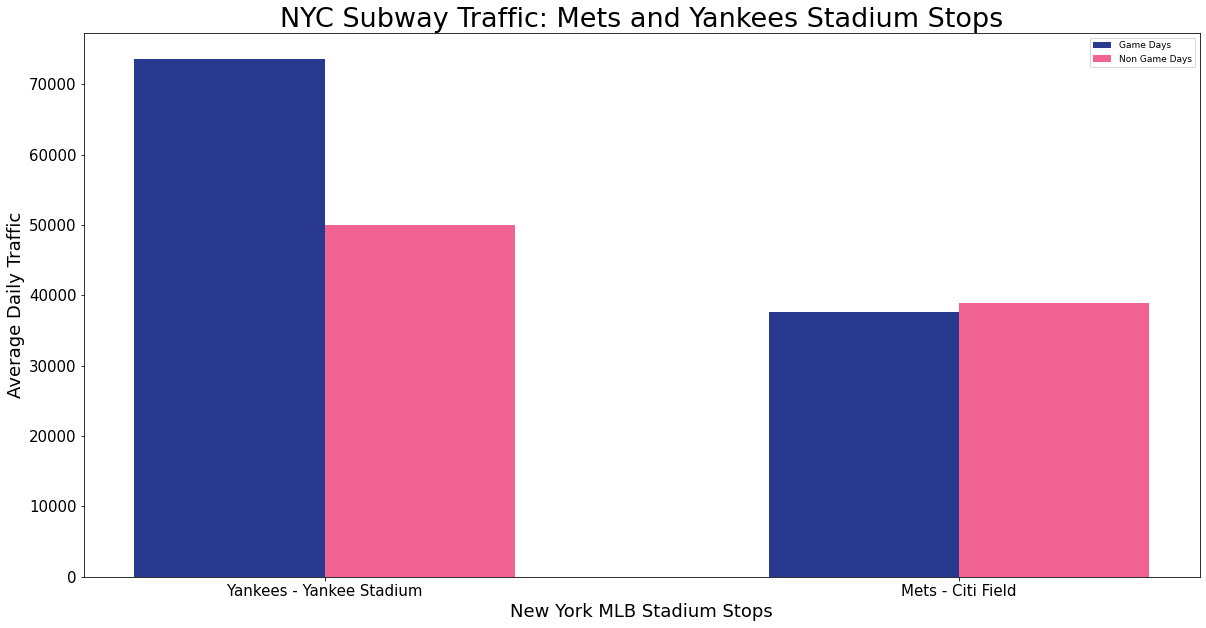

In [93]:
plt.bar(ind, game_days, width, label='Game Days', color = '#2a3990')
plt.bar(ind + width, non_game_days, width, label='Non Game Days', color = '#f06292')
plt.xlabel('New York MLB Stadium Stops', size = 18)
plt.ylabel('Average Daily Traffic', size = 18)
plt.title('NYC Subway Traffic: Mets and Yankees Stadium Stops', size=27)
plt.legend()
plt.xticks(ind + width / 2, ('Yankees - Yankee Stadium', 'Mets - Citi Field'), size=15)
plt.yticks(size=15)
plt.rcParams.update({'font.size': 11})
plt.savefig('nyc_mlb_traffic.jpg');

## NBA Schedule

Target: find gameday vs. non-gameday for knicks/nets

In [94]:
nba_schedule_2019 = pd.read_csv('nba-2018-UTC-08.csv')

In [95]:
nba_schedule_2019.head()

,Round Number,Date,Location,Home Team,Away Team,Result
0,1,16/10/2018 16:00,TD Garden,Boston Celtics,Philadelphia 76ers,NaN
1,1,16/10/2018 18:30,ORACLE Arena,Golden State Warriors,Oklahoma City Thunder,NaN
2,1,17/10/2018 15:00,Spectrum Center,Charlotte Hornets,Milwaukee Bucks,NaN
3,1,17/10/2018 15:00,Little Caesars Arena,Detroit Pistons,Brooklyn Nets,NaN
4,1,17/10/2018 15:00,Bankers Life Fieldhouse,Indiana Pacers,Memphis Grizzlies,NaN


In [96]:
knicks_home_games = nba_schedule_2019[nba_schedule_2019['Home Team'] == 'New York Knicks']
knicks_home_games['Date_Time'] = pd.to_datetime(knicks_home_games['Date'], dayfirst=True)
knicks_home_games['DateTime'] = knicks_home_games['Date_Time'].dt.date
knicks_home_games['DateTime'] = pd.to_datetime(knicks_home_games['DateTime'])
knicks_home_games.sort_values(['Date_Time']).tail(15)

<ipython-input-96-e409209f8ce1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_home_games['Date_Time'] = pd.to_datetime(knicks_home_games['Date'], dayfirst=True)
<ipython-input-96-e409209f8ce1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_home_games['DateTime'] = knicks_home_games['Date_Time'].dt.date
<ipython-input-96-e409209f8ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,Round Number,Date,Location,Home Team,Away Team,Result,Date_Time,DateTime
855,17,13/02/2019 16:30,Madison Square Garden,New York Knicks,Philadelphia 76ers,NaN,2019-02-13 16:30:00,2019-02-13
877,18,22/02/2019 16:30,Madison Square Garden,New York Knicks,Minnesota Timberwolves,NaN,2019-02-22 16:30:00,2019-02-22
895,18,24/02/2019 16:30,Madison Square Garden,New York Knicks,San Antonio Spurs,NaN,2019-02-24 16:30:00,2019-02-24
907,18,26/02/2019 16:30,Madison Square Garden,New York Knicks,Orlando Magic,NaN,2019-02-26 16:30:00,2019-02-26
923,19,28/02/2019 16:30,Madison Square Garden,New York Knicks,Cleveland Cavaliers,NaN,2019-02-28 16:30:00,2019-02-28
985,20,09/03/2019 09:00,Madison Square Garden,New York Knicks,Sacramento Kings,NaN,2019-03-09 09:00:00,2019-03-09
1041,21,17/03/2019 08:00,Madison Square Garden,New York Knicks,Los Angeles Lakers,NaN,2019-03-17 08:00:00,2019-03-17
1067,21,20/03/2019 15:30,Madison Square Garden,New York Knicks,Utah Jazz,NaN,2019-03-20 15:30:00,2019-03-20
1081,22,22/03/2019 15:30,Madison Square Garden,New York Knicks,Denver Nuggets,NaN,2019-03-22 15:30:00,2019-03-22
1094,22,24/03/2019 08:00,Madison Square Garden,New York Knicks,LA Clippers,NaN,2019-03-24 08:00:00,2019-03-24


In [97]:
nets_home_games = nba_schedule_2019[nba_schedule_2019['Home Team'] == 'Brooklyn Nets']
nets_home_games['Date_Time'] = pd.to_datetime(nets_home_games['Date'], dayfirst=True)
nets_home_games['DateTime'] = nets_home_games['Date_Time'].dt.date
nets_home_games['DateTime'] = pd.to_datetime(nets_home_games['DateTime'])
nets_home_games.tail(15)

<ipython-input-97-f15d5bcb479e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_home_games['Date_Time'] = pd.to_datetime(nets_home_games['Date'], dayfirst=True)
<ipython-input-97-f15d5bcb479e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_home_games['DateTime'] = nets_home_games['Date_Time'].dt.date
<ipython-input-97-f15d5bcb479e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,Round Number,Date,Location,Home Team,Away Team,Result,Date_Time,DateTime
751,15,29/01/2019 16:30,Barclays Center,Brooklyn Nets,Chicago Bulls,NaN,2019-01-29 16:30:00,2019-01-29
791,16,04/02/2019 16:30,Barclays Center,Brooklyn Nets,Milwaukee Bucks,NaN,2019-02-04 16:30:00,2019-02-04
803,16,06/02/2019 16:30,Barclays Center,Brooklyn Nets,Denver Nuggets,NaN,2019-02-06 16:30:00,2019-02-06
819,17,08/02/2019 16:30,Barclays Center,Brooklyn Nets,Chicago Bulls,NaN,2019-02-08 16:30:00,2019-02-08
868,18,21/02/2019 16:30,Barclays Center,Brooklyn Nets,Portland Trail Blazers,NaN,2019-02-21 16:30:00,2019-02-21
899,18,25/02/2019 16:30,Barclays Center,Brooklyn Nets,San Antonio Spurs,NaN,2019-02-25 16:30:00,2019-02-25
913,18,27/02/2019 16:30,Barclays Center,Brooklyn Nets,Washington Wizards,NaN,2019-02-27 16:30:00,2019-02-27
928,19,01/03/2019 16:30,Barclays Center,Brooklyn Nets,Charlotte Hornets,NaN,2019-03-01 16:30:00,2019-03-01
951,19,04/03/2019 16:30,Barclays Center,Brooklyn Nets,Dallas Mavericks,NaN,2019-03-04 16:30:00,2019-03-04
968,19,06/03/2019 16:30,Barclays Center,Brooklyn Nets,Cleveland Cavaliers,NaN,2019-03-06 16:30:00,2019-03-06


In [98]:
#Dropping columns that are not needed for merging the files
knicks_home_games.drop(columns = ['Date', 'Round Number','Away Team','Result', 'Date_Time'], inplace=True)
nets_home_games.drop(columns = ['Date', 'Round Number','Away Team','Result', 'Date_Time'], inplace=True)

/Users/patrickbovard/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Madison Square Garden Stops: 34TH ST-HERALD SQ, 34 ST-PENN STA  
Barclays Center Stops: ATL AV-BARCLAY, FULTON ST, LAFAYETTE AV

Making a mask for the KNicks and Nets Stadium Stops:

In [99]:
msg_mask = ((grouped_time.STATION == '34 ST-HERALD SQ') | (grouped_time.STATION == '34 ST-PENN STA'))
barclays_mask = ((grouped_time.STATION == 'ATL AV-BARCLAY') | (grouped_time.STATION == 'FULTON ST') | (grouped_time.STATION == 'LAFAYETTE AV'))

In [100]:
grouped_time[barclays_mask].STATION.value_counts()

FULTON ST         44311
ATL AV-BARCLAY    22147
LAFAYETTE AV       4555
Name: STATION, dtype: int64

In [101]:
grouped_time[msg_mask].STATION.value_counts()

34 ST-PENN STA     45785
34 ST-HERALD SQ    24756
Name: STATION, dtype: int64

### Creating a dataframe for knicks games only:

In [102]:
knicks_df = grouped_time[msg_mask]
knicks_df.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC
2951,34 ST-HERALD SQ,BMT,2019-05-11,04:00:00,2019-05-11 04:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,254.0
2952,34 ST-HERALD SQ,BMT,2019-05-11,08:00:00,2019-05-11 08:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,158.0
2953,34 ST-HERALD SQ,BMT,2019-05-11,12:00:00,2019-05-11 12:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,807.0
2954,34 ST-HERALD SQ,BMT,2019-05-11,16:00:00,2019-05-11 16:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,1640.0
2955,34 ST-HERALD SQ,BMT,2019-05-11,20:00:00,2019-05-11 20:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,1746.0


Converting the date to datetime to match with teh schedule data:

In [103]:
knicks_df['DateTime'] = pd.to_datetime(knicks_df['DATE'], cache=True)

<ipython-input-103-a92c4ca7619e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knicks_df['DateTime'] = pd.to_datetime(knicks_df['DATE'], cache=True)


In [104]:
knicks_df.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime
2951,34 ST-HERALD SQ,BMT,2019-05-11,04:00:00,2019-05-11 04:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,254.0,2019-05-11
2952,34 ST-HERALD SQ,BMT,2019-05-11,08:00:00,2019-05-11 08:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,158.0,2019-05-11
2953,34 ST-HERALD SQ,BMT,2019-05-11,12:00:00,2019-05-11 12:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,807.0,2019-05-11
2954,34 ST-HERALD SQ,BMT,2019-05-11,16:00:00,2019-05-11 16:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,1640.0,2019-05-11
2955,34 ST-HERALD SQ,BMT,2019-05-11,20:00:00,2019-05-11 20:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,1746.0,2019-05-11


Joining the knicks game schedule with subway data:

In [105]:
knicks_home_games.head()

,Location,Home Team,DateTime
6,Madison Square Garden,New York Knicks,2018-10-17
27,Madison Square Garden,New York Knicks,2018-10-20
67,Madison Square Garden,New York Knicks,2018-10-26
89,Madison Square Garden,New York Knicks,2018-10-29
104,Madison Square Garden,New York Knicks,2018-10-31


In [106]:
joined_knicks_df = knicks_df.merge(knicks_home_games, how='left', on='DateTime')
joined_knicks_df.sample(10)

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,Location,Home Team
22444,34 ST-HERALD SQ,IND,2019-06-04,16:00:00,2019-06-04 16:00:00,N505R02202-00-0534 ST-HERALD SQ,Tuesday,199.0,2019-06-04,NaN,NaN
34847,34 ST-PENN STA,IND,2019-05-26,12:00:00,2019-05-26 12:00:00,N073R01302-00-0834 ST-PENN STA,Sunday,68.0,2019-05-26,NaN,NaN
9407,34 ST-PENN STA,IND,2019-05-18,00:00:00,2019-05-18 00:00:00,N073R01302-00-0534 ST-PENN STA,Saturday,124.0,2019-05-18,NaN,NaN
35639,34 ST-HERALD SQ,IND,2019-05-28,16:00:00,2019-05-28 16:00:00,N506R02200-03-0334 ST-HERALD SQ,Tuesday,346.0,2019-05-28,NaN,NaN
41669,34 ST-HERALD SQ,IND,2019-06-10,08:00:00,2019-06-10 08:00:00,N505R02202-00-0934 ST-HERALD SQ,Monday,298.0,2019-06-10,NaN,NaN
27624,34 ST-PENN STA,IND,2019-04-22,16:00:00,2019-04-22 16:00:00,N071R01300-00-0434 ST-PENN STA,Monday,552.0,2019-04-22,NaN,NaN
55680,34 ST-HERALD SQ,IND,2019-04-07,12:00:00,2019-04-07 12:00:00,N507R02300-03-0534 ST-HERALD SQ,Sunday,318.0,2019-04-07,Madison Square Garden,New York Knicks
40978,34 ST-PENN STA,IND,2019-06-08,12:00:00,2019-06-08 12:00:00,N073R01302-00-0234 ST-PENN STA,Saturday,344.0,2019-06-08,NaN,NaN
9258,34 ST-PENN STA,IND,2019-05-21,04:00:00,2019-05-21 04:00:00,N073R01302-00-0134 ST-PENN STA,Tuesday,68.0,2019-05-21,NaN,NaN
37401,34 ST-PENN STA,IRT,2019-05-31,14:00:00,2019-05-31 14:00:00,R138R29300-03-0234 ST-PENN STA,Friday,992.0,2019-05-31,NaN,NaN


Filling na's with "NoGame" for easier filtering:

In [107]:
joined_knicks_df['Home Team'].fillna('NoGame', inplace=True)

Adding masks for games/nongamedays for the Knicks:

In [108]:
knicks_game_mask = (joined_knicks_df['Home Team'] == 'New York Knicks')
non_knicks_game_mask = (joined_knicks_df['Home Team'] == 'NoGame')

In [109]:
joined_knicks_df[knicks_game_mask]

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC,DateTime,Location,Home Team
44709,34 ST-HERALD SQ,BMT,2019-03-30,00:00:00,2019-03-30 00:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,0.0,2019-03-30,Madison Square Garden,New York Knicks
44710,34 ST-HERALD SQ,BMT,2019-03-30,04:00:00,2019-03-30 04:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,228.0,2019-03-30,Madison Square Garden,New York Knicks
44711,34 ST-HERALD SQ,BMT,2019-03-30,08:00:00,2019-03-30 08:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,132.0,2019-03-30,Madison Square Garden,New York Knicks
44712,34 ST-HERALD SQ,BMT,2019-03-30,12:00:00,2019-03-30 12:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,792.0,2019-03-30,Madison Square Garden,New York Knicks
44713,34 ST-HERALD SQ,BMT,2019-03-30,16:00:00,2019-03-30 16:00:00,A022R02201-00-0034 ST-HERALD SQ,Saturday,1587.0,2019-03-30,Madison Square Garden,New York Knicks
...,...,...,...,...,...,...,...,...,...,...,...
57618,34 ST-PENN STA,IRT,2019-04-10,06:00:00,2019-04-10 06:00:00,R142R29301-06-0134 ST-PENN STA,Wednesday,18.0,2019-04-10,Madison Square Garden,New York Knicks
57619,34 ST-PENN STA,IRT,2019-04-10,10:00:00,2019-04-10 10:00:00,R142R29301-06-0134 ST-PENN STA,Wednesday,617.0,2019-04-10,Madison Square Garden,New York Knicks
57620,34 ST-PENN STA,IRT,2019-04-10,14:00:00,2019-04-10 14:00:00,R142R29301-06-0134 ST-PENN STA,Wednesday,438.0,2019-04-10,Madison Square Garden,New York Knicks
57621,34 ST-PENN STA,IRT,2019-04-10,18:00:00,2019-04-10 18:00:00,R142R29301-06-0134 ST-PENN STA,Wednesday,566.0,2019-04-10,Madison Square Garden,New York Knicks


In [110]:
#Avg. Knicks Gameday Traffic:
knicks_gameday_df = joined_knicks_df[knicks_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
knicks_gameday_df

,DateTime,TOTAL_TRAFFIC
0,2019-03-30,439474.0
1,2019-04-01,545645.0
2,2019-04-07,288439.0
3,2019-04-10,579471.0


In [111]:
knicks_gameday_traffic = knicks_gameday_df['TOTAL_TRAFFIC'].mean()
knicks_gameday_traffic

463257.25

In [112]:
#Avg. Knicks Non-Gameday Traffic:
knicks_non_gameday_df = joined_knicks_df[non_knicks_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
knicks_non_gameday_df

,DateTime,TOTAL_TRAFFIC
0,2019-03-31,271738.0
1,2019-04-02,568251.0
2,2019-04-03,576781.0
3,2019-04-04,582824.0
4,2019-04-05,587155.0
...,...,...
68,2019-06-10,547329.0
69,2019-06-11,563709.0
70,2019-06-12,614334.0
71,2019-06-13,593877.0


In [113]:
knicks_non_gameday_traffic = knicks_non_gameday_df['TOTAL_TRAFFIC'].mean()
knicks_non_gameday_traffic

525810.205479452

In [114]:
#Percent Difference:
knicks_diff = knicks_gameday_traffic-knicks_non_gameday_traffic
knicks_percent = (knicks_gameday_traffic-knicks_non_gameday_traffic)/knicks_non_gameday_traffic * 100
print("Total difference between GameDay and Non-GameDay Traffic for New York Knicks: {}".format(knicks_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for New York Knicks: {}%".format(knicks_percent))

Total difference between GameDay and Non-GameDay Traffic for New York Knicks: -62552.95547945204
Percent difference between GameDay and Non-GameDay Traffic for New York Knicks: -11.896489422911461%


### Repeating above, but for Nets:

In [115]:
nets_df = grouped_time[barclays_mask]
nets_df.head()

,STATION,DIVISION,DATE,TIME,Date_Time,Turnstile,Week_Day,TOTAL_TRAFFIC
12643,FULTON ST,BMT,2019-05-11,07:00:00,2019-05-11 07:00:00,A077R02803-00-00FULTON ST,Saturday,12.0
12644,FULTON ST,BMT,2019-05-11,11:00:00,2019-05-11 11:00:00,A077R02803-00-00FULTON ST,Saturday,66.0
12645,FULTON ST,BMT,2019-05-11,15:00:00,2019-05-11 15:00:00,A077R02803-00-00FULTON ST,Saturday,129.0
12646,FULTON ST,BMT,2019-05-11,19:00:00,2019-05-11 19:00:00,A077R02803-00-00FULTON ST,Saturday,215.0
12647,FULTON ST,BMT,2019-05-11,23:00:00,2019-05-11 23:00:00,A077R02803-00-00FULTON ST,Saturday,103.0


In [116]:
nets_df['DateTime'] = pd.to_datetime(nets_df['DATE'], cache=True)

<ipython-input-116-f3b98e81cec6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nets_df['DateTime'] = pd.to_datetime(nets_df['DATE'], cache=True)


Joining the nets game schedule with subway data:

In [117]:
nets_home_games.head()
nets_home_games.DateTime.value_counts()

2019-01-21    1
2018-11-23    1
2019-01-23    1
2018-11-04    1
2018-12-05    1
2018-12-14    1
2019-01-09    1
2018-10-28    1
2018-11-28    1
2019-01-29    1
2019-03-01    1
2019-02-04    1
2019-01-25    1
2018-12-16    1
2018-12-26    1
2018-11-02    1
2018-12-03    1
2019-03-06    1
2018-11-14    1
2019-02-08    1
2018-12-18    1
2019-02-21    1
2018-11-17    1
2019-01-02    1
2018-12-23    1
2019-04-01    1
2018-10-19    1
2019-01-14    1
2018-11-25    1
2018-10-31    1
2018-12-07    1
2019-03-30    1
2019-03-04    1
2019-04-03    1
2019-04-10    1
2019-02-27    1
2018-11-30    1
2019-02-25    1
2019-03-11    1
2019-02-06    1
2018-12-21    1
Name: DateTime, dtype: int64

In [118]:
joined_nets_df = nets_df.merge(nets_home_games, how='left', on='DateTime')
joined_nets_df.DATE.value_counts()

2019-05-15    1120
2019-05-16    1106
2019-05-17    1093
2019-05-21    1076
2019-06-03    1076
              ... 
2019-06-01     826
2019-04-20     808
2019-03-30     806
2019-05-11     760
2019-04-13     753
Name: DATE, Length: 77, dtype: int64

Filling na's with "NoGame" for easier filtering:

In [119]:
joined_nets_df['Home Team'].fillna('NoGame', inplace=True)

Adding masks for games/nongamedays for the nets:

In [120]:
nets_game_mask = (joined_nets_df['Home Team'] == 'Brooklyn Nets')
non_nets_game_mask = (joined_nets_df['Home Team'] == 'NoGame')

In [121]:
#Avg. Nets Gameday Traffic: first, finding total traffic on each gameday:
nets_gameday_df = joined_nets_df[nets_game_mask].groupby(['DateTime'], as_index = False).TOTAL_TRAFFIC.sum()
nets_gameday_df

,DateTime,TOTAL_TRAFFIC
0,2019-03-30,505658.0
1,2019-04-01,277963.0
2,2019-04-03,296186.0
3,2019-04-10,286300.0


In [122]:
#Averaging total traffic on each game day: 
nets_gameday_traffic = nets_gameday_df.TOTAL_TRAFFIC.mean()
nets_gameday_traffic

341526.75

In [123]:
#Avg. Nets Non-Gameday Traffic: first, finding total traffic on each non-gameday:
nets_non_gameday_df = joined_nets_df[non_nets_game_mask].groupby(['DateTime'], as_index=False).TOTAL_TRAFFIC.sum()
nets_non_gameday_df

,DateTime,TOTAL_TRAFFIC
0,2019-03-31,104384.0
1,2019-04-02,291959.0
2,2019-04-04,300436.0
3,2019-04-05,291956.0
4,2019-04-06,155713.0
...,...,...
68,2019-06-10,267391.0
69,2019-06-11,279849.0
70,2019-06-12,297730.0
71,2019-06-13,294373.0


In [124]:
#Averaging total traffic on each game day:
nets_non_gameday_traffic = nets_non_gameday_df.TOTAL_TRAFFIC.mean()
nets_non_gameday_traffic

299335.16438356164

In [125]:
#Percent Difference:
nets_diff = (nets_gameday_traffic - nets_non_gameday_traffic)
nets_percent = (nets_gameday_traffic - nets_non_gameday_traffic) / nets_non_gameday_traffic * 100
print("Total difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: {}".format(nets_diff))
print("Percent difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: {}%".format(nets_percent))

Total difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: 42191.58561643836
Percent difference between GameDay and Non-GameDay Traffic for Brooklyn Nets: 14.09509828333265%


Plotting as a bar chart:

In [126]:
nba_game_days = (knicks_gameday_traffic, nets_gameday_traffic) 
non_nba_game_days = (knicks_non_gameday_traffic, nets_non_gameday_traffic)

In [127]:
N = 2
ind = np.arange(N)
width = 0.3

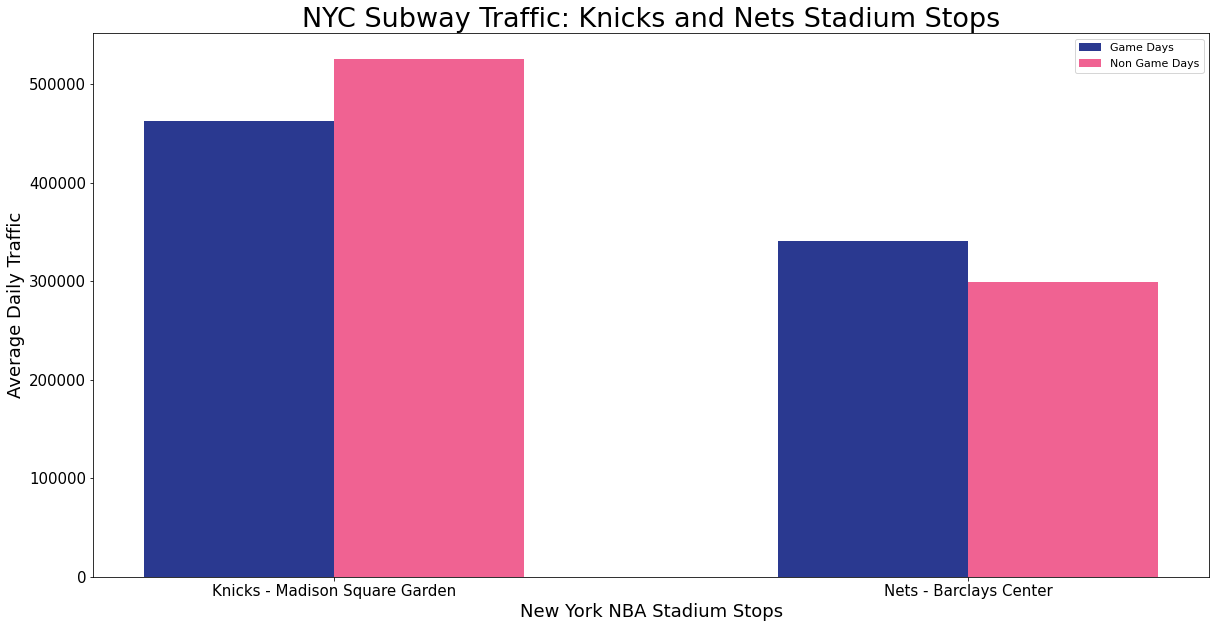

In [128]:
plt.bar(ind, nba_game_days, width, label='Game Days', color = '#2a3990')
plt.bar(ind + width, non_nba_game_days, width, label='Non Game Days', color = '#f06292')
plt.xlabel('New York NBA Stadium Stops', fontsize=18)
plt.ylabel('Average Daily Traffic', fontsize=18)
plt.title('NYC Subway Traffic: Knicks and Nets Stadium Stops', fontsize=27)
plt.legend()
plt.xticks(ind + width / 2, ('Knicks - Madison Square Garden', 'Nets - Barclays Center'), fontsize=15)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 11})
plt.savefig('nyc_nba_traffic.jpg');